In [1]:
import pypsa
from FLUCCOplus import plots
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from datetime import date, datetime, timedelta
import datetime as dt
from scipy.fft import fft, fftfreq
import math 
import operator
import os.path as osp
n = pypsa.Network('elec_s_10_ec_lcopt_Co2L-1H.nc')

FLUCCOplus.config  loaded!
FLUCCOplus.notebooks loaded!


# Organisation
## Ordnerstruktur
Der Workflow ist in dem Ordner 'pypsa-eur' enthalten. Dieser hat eine bestimmte Ordnerstruktur, auf die von verschiedenen Skripts zugegriffen wird, weshalb sie nicht verändert oder umbenannt werden darf. Darin befinden sich folgende Ordner:
- benchmark
- cutouts
- data
- doc
- env
- envs
- LICENCES
- logs
- networks
- resources
- results
- scripts
- summary
- test

und Dateien: 

- borg-it
- CITATION-cff
- config_[].yaml
- README.md
- Snakefile

und versteckte Ordner bzw. Dateien, die für den Worflow ebenfalls unerlässlich sind: 
- .git
- .gitattribute
- .github
- .gitignore
- .readthedocs.yml
- .reuse
- .snakemake

Für den Ordner 'summary' ist eine genauere Betrachtung noch sinnvoll, da die Ergebnisse hier gespeichert und geordnet werden. Im Folder summary/Netzwerkanalyse befindet sich das Auwertungs-skript `Auswertung.py`. Dieses erstellt einen Ordner `result_files`, der die Ergebnisse der letzten Auswertung enthält. Bei Vergleich mehrerer Netzwerke ist es sinnvoll, diesen Ordner nach Auführung des Skriptes umzubenennen, da er ansonsten mit den Ergebnisdaten der nächsten Auswertung überschrieben wird.

Wird das Auswertungsskript händisch ausgeführt, so muss das nc-file des auszuwertenden Netzwerks im gleichen Ordner wie das Skript liegen, also im Ordner 'Netzwerkanalyse'. Im config-file, das sich ebenfalls in diesem Ordner befindet, ist der Name dieses nc-Files anzugeben. Bei Durchlaufen des Workflows mit Erstellung des Netzwerks wird automatisch das im Workflow erstellte Netzwerk als Input für das Auswertungsskript verwendet. (Die Integration der Auswertung in den pypsa-workflow wird vermutlich erst nach Abgabe der Masterarbeit durchgeführt werden, das Skript für die Auswertung muss also händisch ausgeführt werden.)

**Die Ergebnisse der Auswertung sind im Ordner 'result_files' gespeichert.** Alle Ergebnisse einer Netzwerkanalyse werden dabei in der Datei 'all results.xlsx' auf unterschiedlichen Tabellenblättern zusammengefasst. Zudem liegen sie in Form von csv-files vor, um in weiteren Schritten leichter verarbeitet werden zu können. Welche Daten in welcher Datei enthalten sind  ist in diesem Dokument bei der Aufführung der Ergebnisse angegeben. Im Ordner 'result_files/Plots' sind die grafischen Aufbereitungen der Ergebnisse in Unterordner geordnet gespeichert. Weitere Informationen zur Netzwerkauswertung und den resultierenden Dateien sind in dem Abschnitt 'Auswertung' zusammengefasst.

## environment
Um die Abhängigkeiten, auf denen der Code aufbaut zu erfüllen ist es ratsam, eine entsprechende Umgebung einzurichten. Der Anaconda-Packagemanager eignet sich dafür, da er besonders auf die Programmiersprache Python zugeschnitten ist. Im Ordner 'pypsa/envs' finden sich drei yaml-Dateien. In der Datei 'environment.aut.yaml' sind die Abhängigkeiten des vorliegenden Workflows gespeichert. Mit dem Shell-Befehl 

    conda env create -f environment.aut.yml

wird die Programmierumgebung 'pypsa-aut' geschaffen. Dies kann einige Zeit dauern. Die Umgebung kann danach mit `conda activate pypsa-aut` aktiviert und mit `conda deactivate` deaktiviert werden. Voraussetzung dafür ist die Installation von miniconda bzw. Anaconda. Die Installations-Aleitung ist hier zu finden: https://docs.conda.io/projects/conda/en/latest/user-guide/install/


## Gurobi-Solver
Zum Lösen und Optimieren des Netzwerks ist ein proprietärer Solver notwendig. Der Workflow ist im Anfangszustand auf den Gurobi-Solver ausgerichtet, da dieser eine gratis Studentenlizenz anbietet. Bei Wechsel des Solvers muss dies in der Datei 'pypsa-eur/config.[].yaml' angegeben werden und die entsprechenden Variablen des Solvers neu gesetzt werden. Die akademische Lizenz des Gurobi-Solvers kann unter https://www.gurobi.com/downloads/free-academic-license/ beantragt werden und wird als Datei im home-Verzeichnis (oder einem entsprechenden Äquivalent anderer Betriebssysteme) gespeichert. Sie gilt für einige Monate. 
Ist bereits ein Lizenzfile vorhanden wird dieses bei Verlängerung der Lizenz überschrieben.

## Copernicus Climate Data Store
Um auf die benötigten Klimadaten zugreifen zu können ist ein Zugang im Copernicus Climate Data Store notwendig. Dieser kann wie unter https://cds.climate.copernicus.eu/api-how-to beschrieben einfach eingerichtet werden. Die Anmeldung zeigt keine direkte Erfolgsmeldung, sollte bei der Anmeldung ein fehler passiert sein, gibt beim folgenden Durchlauf des Workflows das Skript `rule build_cutout` einen Fehler aus. Zudem muss danach das `cdsapi` package mit pip installiert werden.

## Config-File
Das config.[].yaml file dient als Datei, in der die Grundeinstellungen für den Workflow vorgenommen werden können. Dabei sind mehrere config-files im Ordner pypsa-eur enthalten. Das bei Download aktive file heißt 'config.default.yaml'. Allgemeine Einstellungen in dieser Datei sind so gesetzt, dass ein Durchlauf eines Workflows möglich ist und alle Daten, die beim ersten Durchlauf des Programms neu geladen werden müssen geladen werden.

Wenn das aktive Config-file geändert werden soll ist diese Veränderung im 'Snakefile' anzugeben. In Zeile 14 ist das File für den Input der Einstellungen festgesetzt. Ist kein File festgesetzt wird auf das 'config.default.yaml'-File zugegriffen.

## Programmdurchlauf
Um die gesamte Auswertung durchzunehmen müssen zur Zeit 2 Shell-Befehle ausgeführt werden, da das Miteinbeziehen der Auswertung in einen Workflow wird vermutlich erst nach Abgabe der Masterarbeit implementiert werden. 

Zum Erstellen und Lösen des elektrischen Netzwerks ist ein Snakemake-Workflow implementiert, der durch einen Shell-Befehl ausgeführt werden kann. Dafür muss die Conda-Umgebung aktiv sein und das Config-File im Ordner 'pypsa-eur' enthalten sein.

    conda activate pypsa-aut
    snakemake -j 1 results/networks/elec_s_10_ec_lcopt_C02L-1H.nc -n 
gibt einen Überblick über die durchzuführenden Skripte und Anzahl der Schritte, welcher mit einer Zusammenfassung endet. Dies kann bei einem gesamten Durchlauf beispielsweise so aussehen: 

    Job stats:
    job                         count    min threads    max threads
    ------------------------  -------  -------------  -------------
    add_electricity                 1              1              1
    add_extra_components            1              1              1
    auswertung                      1              1              1
    base_network                    1              1              1
    build_bus_regions               1              1              1
    build_hydro_profile             1              1              1
    build_load_data                 1              1              1
    build_powerplants               1              1              1
    build_renewable_profiles        4              1              1
    build_shapes                    1              1              1
    cluster_network                 1              1              1
    prepare_links_p_nom             1              1              1
    prepare_network                 1              1              1
    retrieve_cutout                 2              1              1
    retrieve_databundle             1              1              1
    retrieve_natura_raster          1              1              1
    simplify_network                1              1              1
    solve_network                   1              1              1
    total                          22              1              1

Die Flag `-n` bedeutet dabei, dass es sich um einen dry-run handelt. Ohne diese Flag werden die angekündigten Jobs durchgeführt und der Workflow begonnen. Dabei entspricht die Reihenfolge der Skripte der logischen Reihenfolge, und ergibt sich aus den Outputs und nötigen Inputs der einzelnen Skripte. Dies ist nicht die hier dargestellte Reihenfolge. Weitere evtl. nützliche Flags und Command Line Interfaces sind hier zusammengefasst: https://snakemake.readthedocs.io/en/stable/executing/cli.html . Der Workflow zum Erstellen und Lösen des elektrischen Netzwerkes wird folglich mit 

    snakemake -j 1 results/networks/elec_s_10_ec_lcopt_C02L-1H.nc
    
begonnen. Woraus sich der Name der Datei zusammensetzt kann aus dem entsprechenden Absatz der pypsa-readthedocs entnommen werden: https://pypsa-eur.readthedocs.io/en/latest/tutorial.html#how-to-use-the-snakemake-rules . Wichtig ist, dass sich eine Änderung der ersten 20 Zeilen des Config-Files auf den Namen des Netzwerkes auswirkt, weil der Name die grundlegenden Eigenschaften der Struktur beschreibt, die in diesen Zeilen definiert werden.

Das fertige Netzwerk-File, welches sich unter 'results/networks/elec_s_10_ec_lcopt_C02L-1H.nc' finden lässt, dient dann als Basis für die Auswertung. Dafür muss es in den Ordner 'summary/Netzwerkanalyse' kopiert werden. Der Name des Netzwerks ist im config-file dieses Ordners anzugeben.

    network:
     filename: 'elec_s_10_ec_lcopt_C02L-1H.nc'

Das hat den Grund, dass mehrere elektrische Netzwerke ausgewertet werden können und die Ergebnisse damit schneller vergleichbar sind bzw. Auswertungsschritte wiederholt werden können. Ebenso ist in diesem File festzulegen, welche Größen der Residuallast ausgewertet werden sollen:

    evaluation: 
     residual_load_ordered: true
     zero_crossings: true  
     duration_line: true 
     duration_statistics: true 
     load_shifting_simulation: true
     signals: true

Die durchzuführenden Auswertungsschritte sind mit ` true` anzugeben. Das Auswertungs-Skript kann dann mit 

    python3 Auswertung.py
    
im Ordner 'Netzwerkanalyse' ausgeführt werden. 

# Arbeitsschritte des Workflows
Der gesamte Workflow vom Erstellen des Netzwerks bis zur Auswertung der Residuallast und der Beantwortung der Fragestellung wird in 5 Schritte geteilt: 
- Erstellen des Basis-Netzwerks
- Erstellen der Verfügbarkeits- und Erzeugungsprofile
- Erstellen eines fiktiven optimierbaren Netzwerks
- numerisches Lösen des Netzwerks
- Auswerten der Lösung

## Erstellen des Basisnetzwerks
**Ergebnis des Schrittes:** Basis-Netzwerk mit geographischer Anordnung der Netzwerkknotenpunkte

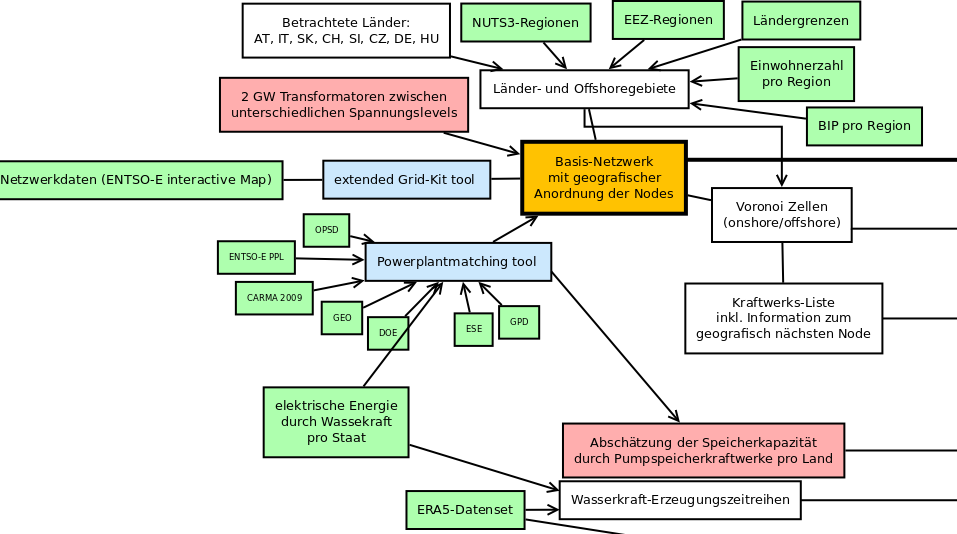
_**Erster Schritt des Workflows.** Grüne Einträge stellen Inputs dar, deren Quellen in den nächsten Absätzen aufgelistet sind. Blaue Einträge kennzeichnen externe Tools, die für den Workflow verwendet werden und auf die inhaltlich nicht genauer eingegangen wird._

In diesem ersten Schritt werden Daten aus unterschiedlichen Quellen zusammengetragen, um die Netzstruktur, wie sie heutzutage besteht, abzubilden. Dabei werden 
- geographische Länderdaten
- Netzwerkdaten
- Daten über bestehende konventionelle Kraftwerke

verarbeitet. 

### Geographische Daten
- Betrachtete Länder: werden in der config-datei des Workflows festgesetzt: Österreich, Italien, Slowakei, Schweiz, Slowenien, Tschechien, Deutschland, Ungarn
- Ländergrenzen: werden mit dem Skript `retrieve_databundle` heruntergeladen und im Skript `build_shapes` das erste Mal verabeitet; Datenquelle der Ländergrenzen: https://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-0-countries/ , letzter Zugriff 3.11.2021
- Ausschließliche Wirtschaftszonen für Deutschland und Italien (EEZ-Regionen): werden mit dem Skript `retrieve_databundle` heruntergeladen und im Skript `build_shapes` das erste Mal verabeitet; Datenquelle der grografischen Daten: http://www.marineregions.org/sources.php#unioneezcountry , letzter Zugriff 3.11.2021
- NUTS3-Regionen der betrachteten Länder: werden mit dem Skript `retrieve_databundle` heruntergeladen und im Skript `build_shapes` das erste Mal verabeitet; Datenquelle der Grenzen:  https://ec.europa.eu/eurostat/web/gisco/geodata/reference-data/administrative-units-statistical-units , letzter Zugriff 10.11.2021
- Einwohnerzahl pro NUTS3-Region: werden mit dem Skript `retrieve_databundle` heruntergeladen; Datenquelle der Einwohnerzahlen:  http://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=nama_10r_3popgdp&lang=en , letzter Zugriff 10.11.2021
- BIP pro NUTS3-Region: werden mit dem Skript `retrieve_databundle` heruntergeladen; Datenquellen für Informationen zum BIP: http://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=nama_10r_3gdp&lang= , letzter Zugriff 3.11.2021; https://www.bfs.admin.ch/bfs/en/home/news/whats-new.assetdetail.7786557.html , letzter Zugriff 3.11.2021

Damit werden die betrachteten Staaten goegraphische eingegrenzt, in NUTS3-Regionen geteilt und Informationen wie das BIP pro Kopf und die Einwohnerzahl zu den entsprechenden NUTS3-Regionen gespeichert.

### Netzwerkdaten
Informationen über Netzwerktopologie werden der ENTSO-E Interactive Map entnommen. Diese stellt das elektrische Netz vom Stand Jänner 2019 dar. Diese OpenStreetMap-Daten werden mit dem externen Tool GridKit in ein elektrisches PyPSA-Netzwerk umgewandelt. Der Code des GridKit-Toolkits ist einsehbar: https://github.com/pypsa/gridkit.

Die Daten werden im Skript `base_network` zu einem PyPSA-Netzwerk verarbeitet. Da in dieser Quelle keine Informationen über Transformatoren enthalten sind werden zwischen unterschiedlichen Spannungsebenen Transformatoren mit einer Kapazität von 2GW ins Netzwerk integriert. Durch diese hohe Einschätzung der Kapazitäten werden "künstliche" Einschränkungen vermieden und das Netzwerk somit numerisch einfacher lösbar gehalten. (Hörsch et al 2018)

Quelle der Netzwerkdaten:
- ENTSO-E (2009): ENTSO-E Transmission System Map, online: https://www.entsoe.eu/data/map/ , letzter Zugriff 10.11.2021

### Daten über bestehende konventionelle Kraftwerke
Um eine wahrheitsgetreue Abbildung konventioneller Kraftwerke zu erreichen werden 6 öffentlich zugängliche Datenbanken kombiniert. Als Basis dient die Transparency-Plattform der ENTSO-E. Bestehende Wasserkraftwerke sind durch diesen Prozess ebenfalls abgebildet und sind zwecks Übersicht in dem Workflow durch einen extra Punkt gekennzeichnet.
- ENTSO-E PPL: ENTSO-E Transparency Platform (2017): Installed Capacity Per ProductionUnit, online: https://transparency.entsoe.eu/generation/r2/installedCapacityPerProductionUnit/show.
- CARMA: K. Ummel, Carma revisited: An updated database of carbon dioxide emissions from power plants worldwide, SSRN Electronic Journal (304). doi:10.2139/ssrn.2226505.
- GEO: Global Energy Observatory, Google, KTH Royal Institute of Technology in Stockholm, Enipedia, World Resources Institute (2018): Global Power Plant Database, online: https://datasets.wri.org/dataset/globalpowerplantdatabase
- DOE: Sandia National Laboratories (2020): DOE OE Global Energy Storage Database, online https://www.sandia.gov/ess-ssl/global-energy-storage-database-home/
- GPD: World Resource Institute (2018): Climate Data and Tools Project, Global Power Plant Database 1.1.0, online: http://datasets.wri.org/dataset/globalpowerplantdatabase .

Die Datenbanken werden mit dem Powerplantmatching-Tool zusammengeführt und beispielsweise auf ähnliche oder doppelte Einträge überprüft. Der Code dafür ist veröffentlicht: https://github.com/FRESNA/powerplantmatching
Für Deutschland, Italien und Ungarn bestehen offizielle Auflistungen aktueller Kraftwerke, die verwendet werden. Die Quelle für diese Länder ist deshalb:
- Open Power System Data (2017): Conventional power plants, online: https://data.open-power-system-data.org/conventional_power_plants/2017-07-07

Die Kraftwerksdaten konventioneller Kraftwerke werden in dem Skript `build_powerplants` erstellt, als _.csv-Datei_ abgespeichert und im dritten Schritt des Workflows weiter bearbeitet. Informationen über Wasserkraftwerke werden im Skript `build_hydro_profiles` extra behandelt was im zweiten Schritt des Workflows näher behandelt wird.

![Ergebnis des Powerplantmatching-prozesses](powerplants.png)
_**Ergebnis des Powerplantmatching-Prozesses:** bestehende konventionelle Kraftwerke und Wasserkraftwerke, die aus unterschiedlichen Quellen zusammengetragen wurden werden in das Netzwerk integriert. Sie können durch Aufrufen des externen Powerplantmatching-Tools grafisch aufbereitet werden._

## Erstellen der Verfügbarkeits- und Erzeugungsprofile
**Ergebnis des Schrittes:** geografisch zuordenbare Verfügbarkeitsprofile für Wind- und Solarenergie und Erzeugungsprofile bestehender Wasserkraftwerke für ein Jahr mit einer zeitlichen Genauigkeit von einer Stunde.

![Zweiter Schritt des Workflows](Workflow(2).png)
_**Zweiter Schritt des Workflows:** Die Voronoi-Zellen werden auf Basis des vorhandenen Netzwerks gebildet und dienen als geografische Ausgangswerte zur Einschätzung der Verfügbarkeit von Solar- und Windenergie. Grüne Einträge stellen Inputs dar. Rote Einträge sind Schritte, deren mathematischer bzw. programmiertechnischer Hintergrund für die weiteren Schritte besonders von Interesse ist und auf die deshalb genauer eingegangen wird._

Im zweiten Schritt werden auf Basis von Wetterdaten und geografischen Daten Zeitreihen für die Erzeugung elektrischer Energie erstellt. Dabei werden
- Solarenergie
- Windenergie
- Wasserkraft

getrennt behandelt. Für Solar- und Windenergie wird dabei von der maximal installierbaren Kapazität ausgegangen, die Erzeugungsprofile der Wasserkraft werden auf Basis der vorhandenen Kraftwerke erstellt. Die dazu verwendeten Wetterdaten werden von der Copernicus Climate Data Store Seite geladen, für die [ein Account erstellt werden muss]( https://cds.climate.copernicus.eu/api-how-t).

Um die verfügbaren Potentiale geografisch zu einem Netzknotenpunkt zuteilen zu können werden durch das Skript `build_bus_regions` Voronoi-Zellen gebildet. In einer Voronoi-Zelle befinden sich dabei alle Punkte, die dem Netzknotenpunkt in dieser Zelle geografisch am nächsten sind. Die Fläche Österreichs wird dabei in 33 Zellen geteilt.
### Verfügbarkeitsprofile für Solarenergie
_Die maximal installierbare Kapazität_ an Solarenergie für eine Einstrahlungsdaten-Zelle wird durch

$G_{x}^{max} = 0.01 * 145 \text{ MW/km²} * A_x$

berechnet. Das technische Potential wird mit 145 MW/km² abgeschätzt (Hörsch et al 2018). Bei dieser Abschätzung wird von einer Flächennutzung von 100% ausgegangen, welche durch den Faktor 0.01 auf 1% Flächennutzung durch Solarenergie beschränkt wird. Die Fläche $A_x$ wird durch die Auswertung des CORINE Land Cover Datensets und des NATURA2000 Datensets bestimmt. Dabei kommen für die Nutzung durch Solarenergie Flächen, die mit "Künstlich angelegte nicht landwirtschaftlich genutzte Flächen", "Hetherogene landwirtschaftliche Flächen" (abgesehen von Waldflächen, welche in einer genaueren Unterteilung der Flächennutzungen bestimmt sind), "Offene Flächen ohne oder mit geringer Vegetation", "Fels" und "Fels mit spärlicher Vegetation" gekennzeichnet sind, infrage. Das CORINE Landcover Datenset kann für Österreich unter https://secure.umweltbundesamt.at/webgis-portal/corine/map.xhtml grafisch aufbereitet betrachtet werden (letzter Zugriff 11.11.2021).

Die Wetterdaten-sets, die für die Berechnung der Kapazität für Solar- und Windenergie verwendet werden, haben eine geografische Auflösung von 30 km x 30 km und sind damit feiner aufgelöst als die Voronoi-Zellen. Die maximalen Kapazitäten pro Voronoi-Zellen werden deshalb für eine Voronoi-Zelle _V_ mit 

$G_{V, x}^{max} = \mathcal{I}_{V,x} * c_x * G_{x}^{max}$


bestimmt, wobei die Indikatormatrix $\mathcal{I}$ durch $\mathcal{I}_{V,x} = \text{area}(V \cap x)/\text{area}(x)$ bestimmt ist, mit $\mathcal{I}_{ij} \in (0,1]$, und $c_x$ die maximale Kapazität einer Zelle des Wetterdaten-sets ist (Hörsch et al 20218). 

_Die maximal verfügbare Leistung_ an Solarenergie pro Voronoi-Zelle und Stunde wird mit der maximal installierbaren Leistung und Auswertung des SARAH2-Datensets bestimmt. Referenzmodell ist eine kristalline Silizium-Solarzelle mit einem Aufstellwinkel von 35 deg. und südlicher Ausrichtung. Die technischen Daten der Zellen sind auf der [Atlite-Seite](https://github.com/PyPSA/atlite/tree/master/atlite/resources/solarpanel) aufgelistet (letzter Zugriff 2.11.2021).

Das SARAH2-Datenset enthält Informationen über solare Einstrahlung auf die Erdoberfläche. Die Daten stammen dabei von den beiden METEOSAT-Satelliten und decken in etwa den geografischen Bereich von Europa und Afrika ab. Es werden die Variablen, welche die direkte und indirekte Einstrahlung, sowie die Temperatur und die Albedo beschreiben, betrachtet (Cionni et al 2017). Die Energie direkter sowie indirekter Einstrahlung sind beispielhaft in der folgenden Grafik abgebildet.

Text(0.5, 1.0, 'Direkte und Indirekte Einstrahlung auf einen Punkt über ein Jahr')

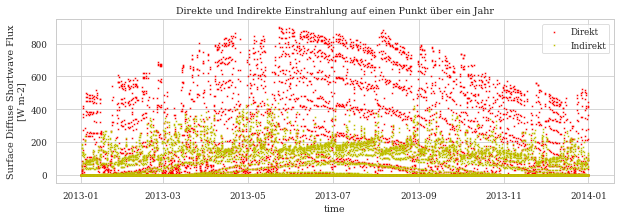

In [2]:
sarah = xr.open_dataset('/home/max/Dokumente/FH/Master_thesis/NEW_pypsa-eur/pypsa-eur/cutouts/europe-2013-sarah.nc')
sp=sarah.isel(x=40,y=8)
plt.figure(figsize=(10,3))
sp.plot.scatter(y = 'influx_direct', x = 'time', s = 2, marker = 'x', color = 'r', label='Direkt')
sp.plot.scatter(y = 'influx_diffuse', x = 'time', s = 2, marker = 'x', color = 'y', label='Indirekt')
plt.legend()
plt.title('Direkte und Indirekte Einstrahlung auf einen Punkt über ein Jahr')

### Verfügbarkeitsprofile für Windenergie
_Die maximal installierbare Kapazität_ an Windenergie für eine Winddaten-Zelle wird durch 

$G_{x}^{max} = 0.3 * 10 \text{ MW/km²} * A_{x}$

berechnet. Dabei ist das technische Potential mit 10 MW/km² abgeschätzt (Quelle: Scholz 2012).  Der Faktor 0.3, ergibt sich aus dem Miteinbeziehen gesellschaftlicher Akzeptanz und anderweitiger Flächennutzung. Die für die Windenergie nutzbare Fläche $A_{x}$ einer Voronoi-Zelle $x$ ergibt sich aus der Auswertung des CORINE Land Cover Datensets und des NATURA2000 Datensets. Flächen, die im CORINE Datenset als "Landwirtschaft" bzw. "Wälder und naturnahe Flächen" eingetragen sind und einen Abstand von mindestens 1 km zu "Städtisch geprägten Flächen" und "Industrie-, Gewerbe- und Verkehrsflächen" aufweisen werden dafür in Betracht gezogen. Flächen, die als NATURA2000-Gebiet eingetragen sind werden exkludiert. 

_Die maximal verfügbare Leistung_ an Windenergie pro Voronoi-Zelle pro Stunde wird auf Basis der maximalen Kapazität berechnet. Es wird die Leistungskurve der Vestas V112-Turbine mit einer Kapazität von 3 MW und Nabenhöhe von 80 m verwendet (Hörsch et al 2018). Die Wetterdaten des ERA5-Datensets enthalten die Windstärke 100 m über dem Boden. Die Daten werden mit dem Logarithmusgesetz 

$u^{h1}(t) = \frac{u^{h2} ln(h/z^0)}{ln(\frac{h^{h2}}{z^0})}$

extrapoliert, um die Windgeschwindigkeit in Nabenhöhe zu bekommen (Hörsch et al 2018). Die technischen Daten der verwendeten Windturbine sind auf der [Atlite-Seite](https://github.com/PyPSA/atlite/tree/master/atlite/resources/windturbine) aufgelistet (letzter Zugriff 2.11.2021).


Datenquellen: 
- SARAH2 Radiation Data Set: Pfeifroth, Uwe; Kothe, Steffen; Müller, Richard; Trentmann, Jörg; Hollmann, Rainer; Fuchs, Petra; Werscheck, Martin (2017): Surface Radiation Data Set - Heliosat (SARAH) - Edition 2, Satellite Application Facility on Climate Monitoring, DOI:10.5676/EUM_SAF_CM/SARAH/V002, https://doi.org/10.5676/EUM_SAF_CM/SARAH/V002.
- Capacity factors durch Weather Data Sets: ERA5-weather-data: Copernicus, European Commission, European Center for Medium Weather Forecast (ECMWF), 2019: ERA5-Land hourly data from 1981 to present, doi:10.24381/cds.e2161bac, downloaded from https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land?tab=overview
- EEA (2012): Corine Land Cover (CLC) , version 18.5.1, downloaded from https://land.copernicus.eu/pan-european/corine-land-cover/clc-2012 
- EEA (2016): Natura 2000 data - the European network of protected sites, downloaded from http://www.eea.europa.eu/data-and-maps/data/natura-7 .
- Scholz Y. (2012: Renewable energy based electricity supply at low costs - Development of the REMix model and application for Europe, Ph.D. thesis, Universität Stuttgart. doi:10.18419/opus-2015

### Erzeugungsprofile der Wasserkraft
Erzeugungsprofile für die Erzeugung mittels Wasserkraftwerken werden auf eine andere Weise erstellt wie die Verfügbarkeitsprofile von Wind- und Solarenergie, da in dem Netzwerkmodell kein Ausbau der Wasserkraft-Kapazitäten betrachtet wird. Die bestehenden Kapazitäten an Wasserkraftwerken sind durch Ausführung des Skripts `build_powerplants`, die im ersten Schritt des Workflows durchgeführt wird, bekannt. Kapazitäten werden eingeteilt in Laufkraftwerke, Speicherwasser-Kraftwerke und Pumpspeicherkraftwerke.

**Szenarien, die einen Ausbau installierten Kapazitäten der Wasserkraftwerke annehmen können noch nicht getreu abgebildet werden. Eine Lösung dafür ist in Arbeit. Bis dorthin kann die Erzeugung mittels bestehender Kapazitäten maximiert werden.**

Die Erzeugungsprofile werden im Skript `build_hydro_profile` erstellt.  Für die Erstellung der Zeitprofile werden die "Runoff"-Daten des ERA5 Datensets verwendet. Diese beinhalten alle Wassermengen, die beispielsweise durch Regen oder Schneeschmelze auf die Erde treffen und damit zur Stromerzeugung mittels Wasserkraftwerken beitragen (Cionni et al 2017). Die resultierenden Wassermengen werden nach Höhenmeter gewichtet und das Datenset normalisiert, um über den Zeitraum von einem Jahr die bekannte Menge elektrischer Energie zu erzeugen. Der mathematische Vorgang ist in (Schlachtberger et al, 2017) beschrieben.

### Abschätzung der Speicherkapazitäten von Pumpspeicherkraftwerken
Da keine öffentlich zugänglichen Daten zu den Kapazitäten bestehender Pumpspeicherkraftwerke verfügbar sind, werden diese auf Basis der gesamten Speicherkapazitäten eines Landes abgeschätzt und auf die verfügbaren Speicherwasser-Kraftwerke und Pumpspeicherkraftwerke aufgeteilt (Hörsch et al 2017). Die geografische Aufteilung der Kapazitäten ist für das Projekt nicht von Relevanz, da sie in einem späteren Schritt wieder zu einem Knotenpunkt zusammengefügt werden.


Links: 
- Übersetzung Speicherwasserkraftwerk: https://austria-forum.org/af/AustriaWiki/Speicherkraftwerk_%28Wasser%29 (letzter Zugriff 22.10.2021)


## Erstellen eines fiktiven optimierbaren Netzwerks
**Ergebnis des Schrittes:** PyPSA-Netzwerk, das die heutige Netzwerk- und Kraftwerksstruktur vereinfacht abbildet und in dem Solar- und Windenergie sowie entsprechende Speicherkapazitäten in Österreich optimiert werden können.

![dritter Schritt des Workflows](Workflow(3).png)
_**Dritter Schritt des Workflows:** Integration von Zeitreihen, Verbrauchsdaten und weiteren Netzwerkelementen_

### Integration der Verbrauchsdaten
Die Verbrauchsdaten der europäischen Länder werden von der Open-Power-System-Data-Seite geladen. Hierfür werden Verbrauchsdaten von 2019 verwendet. Da die Datensets nicht vollständig sind werden sie im Skript `build_load_data` zur weiteren Verarbeitung aufbereitet. Fehlende Daten von 3h oder weniger werden linear interpoliert, für längere Zeiten werden entsprechend ähnliche Ausschnitte des Datensets kopiert und die fehlenden Daten damit ersetzt. Innerhalb eines Landes würden die Daten mit einem Top-down Ansatz auf verschiedene Zellen, die von einem Netzknotenpunkt repräsentiert werden, verteilt. Dabei wird die Last entsprechend des BIP und der Bevölkerung pro Zelle aufgeteilt. Dieser Schritt wird im weiteren vernachlässigt, da Österreich von einem Knotenpunkt repräsentiert wird und die Verbrauchsdaten deshalb direkt aus der erwähnten Datei extrahiert und verarbeitet werden können.

Des weiteren wird in den betrachteten Szenarien ein Anstieg des Verbrauchs angenommen, was durch zwei Funktionen integriert wird. Zum einen werden die Verbrauchsdaten linear skaliert, zum anderen werden die Zeitreihen gemäß einer zeitlichen Verschiebung der Last modifiziert. Diese Parameter können im Config-File unter den Punkten `load: scaling_factor` und `load: time_adjustments` eingestellt werden bzw. ein- oder ausgeschaltet werden.
Für die zeitliche Veränderung der Last wurden Sektoren, die den Stromverbrauch in Zukunft stark beeinflussen werden identifiziert und ihr zeitlicher Einfluss in die Bearbeitung der Daten eingeschlossen:

- Verkehr: starker Anstieg durch Elektromobilität (ca. 12e3 - 29e3 TJ)
    - geht man davon aus, dass ca. 500 PKWs pro 1000 Einwohner sein werden (2020: 570 PKW pro 1000 einwohner), nach (Hezel 2021), eine mittlere Fahrstrecke von 50 km/d und einem mittleren Energiebedarf von 12 kWh pro 100 km (Brauner 2009), ergibt sich ein Elektrizitätsbedarf von **8.8 TWh** pro Jahr (ca. 10% des Energiebedarfs in AUT) => Energieszenario rechnet mit 8.07 MWh (Kalt et al 2016)
    - gesteuerte Ladung in Schwachlastzeiten: **23h - 6h:** Laden mit geringer Ladeleistung (1kW/Auto) und am Tag **bis 18 h:** eine Nachladung von 50 km => 6 kWh/Auto
    - tägliches Potential an Energie zum Verschieben: $27.6*10^3$  MWh, ein Großteil über Nacht (plausibel, ca 25%) 
    - Referenzjahr: 2012

- Industrie: genereller Anstieg (höheres Wirtschaftswachstum in der Industrie) (ca. 1.01e4 - 1.48e4 TJ) (Kalt et al 2016)

Deshalb werden die Lastzeitreihen mit folgenden Parametern modifiziert, welche in der Funktion `varring_adjustments` im Skript `build_load_data` implementiert sind: 

**Tägliche Elemente**
$\rightarrow$ Anzahl der Stützstellen: 12 (2h-Genauigkeit); 

Verkehr: Nachtladung und leichte Tagladungen (1.0) und Spitzenglättung, weil die gesamten Loads 15% gesteigert sind, also der Ausgleich sonst fehlt

| Zeit | Begründung | Wert|
| --- | --- | --- |
| 0 | e-Mobilität | 1.1 |
| 2 | e-Mobilität | 1.1 |
| 4 | e-Mobilität | 1.1 |
| 6 | e-Mobilität | 1.1 |
| 8 | Morgenspitze glätten | 0.95 |
| 10 | Morgenspitze glätten | 0.95 |
| 12 | Verstromung Industrie | 1 |
| 14 | Verstromung Industrie | 1 |
| 16 | Spitze glätten | 0.95 |
| 18 | Spitze glätten | 0.95 |
| 20 | 1 | 1 |
| 22 | e-Mobilität | 1.1 |
| **Total** | Durchschnitt | 1.025 |

der Verbrauch wird damit um 2.5% angehoben.

**Saisonale Elemente**
$\rightarrow$ keine hohe Anzahl an Stützstellen notwendig: 6 Stützstellen gewählt, die alle zwei Monate darstellen

| Zeit | Begründung | Wert|
| --- | --- | --- |
| Jänner | Ausgleich zu Sommer | 0.95 |
| März | Ausgleich zu Sommer | 0.95 |
| Mai | Juni: Anstieg durch Klimaanlagen | 1 |
| Juli | Anstieg durch Klimaanlagen | 1.1 |
| September | Anfang September Klimaanlagen | 1 |
| November | Ausgleich zu Sommer | 1 |
| **Total** | 1 | 1 |

der Verbrauch bleibt damit insgesamt gleich.

Bei der Modellierung der täglichen Änderungen werden trotz zeitlicher Auflösung von 24 Stunden 12 Stützstellen verwendet, da sich ansonsten durch die unterschiedlichen Werte und das Problem des Overfittings ohne eine kompliziertere Veränderung der modellierenden Funktion harmonische Schwingungen ergeben, welche die Modifikation der Verbrauchsdaten verfälschen würde. 


### Optimierbare Elemente
Zusätzlich zu den Verbraucherdaten werden in das Netzwerk zu jedem Netzknotenpunkt Generatoren-Elemente und Speicher-Elemente hinzugefügt. Die Elemente bilden damit Solarkraftwerke, Windkraftwerke, Batteriespeicher und Wasserstoffspeicher ab, die noch nicht zur Energieerzeugung bzw. -speicherung beitragen. Der Ausbau dieser kann in weiterer Folge optimiert werden, so dass die angegebene Menge an elektrischer Energie mit dieser Erzeugungstechnologie in einem Jahr erzeugt werden kann.

Datenquellen: 
- Verbrauchsdaten: Open-Power-System-Data: https://data.open-power-system-data.org/time_series/2019-06-05, letzter Zugriff 20.10.2021


## Vereinfachen des Netzwerks 
**Ziel des Schrittes:** eine Netzwerkbeschreibung mit optimierbarem PyPSA-Netzwerk, die numerisch lösbar ist.

![vierter Schritt des Workfows](Workflow(4).png)
_**Vierter Schritt des Workflows:** Vereinfachung des PyPSA Netzwerks um eine numerische Lösung möglich zu machen_

### Vereinfachung der Netzstruktur
Die Netzstruktur bildet in passender geografischer Auflösung alle Netzebenen ab 220 kV ab. Diese werden in dem Schritt auf eine äquivalente 380 kV Struktur vereinfacht. Das hat für die Ergebnisse des Netzmodells keine direkte Auswirkung, da die Verbindungen der Netzknotenpunkte fiktiv sind, was daraus resultiert, dass jedes Land von einem Netzknotenpunkt repräsentiert wird. Numerisch ist das resultierende Modell jedoch leichter und stabiler lösbar. 

### Clustering
Das Netzwerk wird zu den 10 Netzknotenpunkten, die Österreich und die Nachbarländer, wie im ersten Schritt des Workflows erklärt, abbilden, vereinfacht. Dabei werden Deutschland und Italien von zwei Netzknotenpunkten repräsentiert und es ergibt sich folgende Zellen-Struktur für das Modell des elektrischen Netzwerks. 

![Zellen-Struktur des optimierbaren Netzwerks](countries.png)
_**Zellen-Struktur des optimierbaren Netzwerks:** betrachtetes Gebiet, wobei jede Zelle von einem Netzknotenpunkt im elektrischen Netzwerk repräsentiert wird. Deutschland und Italien werden von je 2 Netzknotenpunkten repräsentiert._

Jede der abgebildeten Zellen wird durch einen Netzknotenpunkt repräsentiert. Diese werden durch das elektrische Netzwerk miteinander verbunden, was in der folgenden Abbildung zu sehen ist. Dabei sind alle Netzknotenpunkte durch elektrische Verbindungen mit den Nodes, die die jeweils benachbarten Zellen repräsentieren, zusammengeschlossen. Die Breite der Verbindungen ist direkt proportional zur maximal transportierbaren Scheinleistung. Sardinien ist mit einer HVDC-Verbindung mit dem italienischen Festland verbunden, welche in dem Plot durch die grüne Farbe gekennzeichnet ist. Ebenso besteht zwischen den Nodes von Italien und der Schweiz neben der Wechselstromverbindung auch eine Gleichstromverbindung. Informationen über bestehende Gleichstromverbindungen werden im Skript `prepare_links_p_nom` geladen und verarbeitet.

Datenquellen:
- bestehende und geplante HVDC-Leitungen: https://en.wikipedia.org/wiki/List_of_HVDC_projects#Europe letzter Zugriff 10.10.2021

Text(0.5, 1.0, 'PyPSA-Netzwerk')

/home/max/anaconda3/envs/pypsa-eur/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning:


The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.



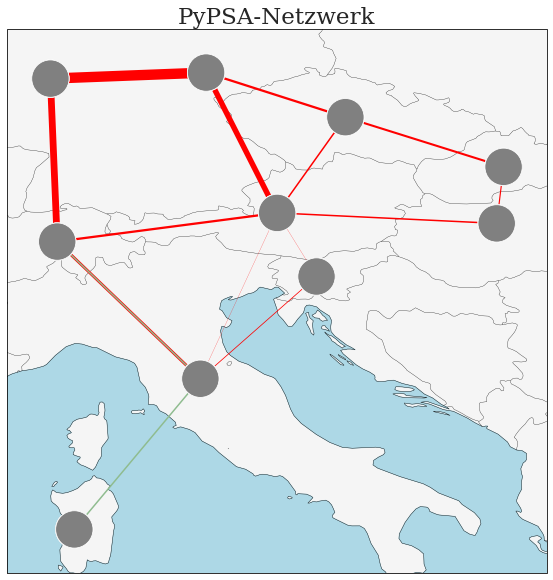

In [3]:
fig,ax = plt.subplots(figsize = (10,10),subplot_kw = {"projection": ccrs.PlateCarree()})
n.plot(ax = ax, bus_colors = 'gray',
    line_widths = n.lines.s_nom/3e3,
    line_colors = 'red',
    color_geomap = True,
    line_cmap = plt.cm.viridis,
    bus_sizes = 0.2)
plt.title("PyPSA-Netzwerk", fontsize = 23)

Das Modell des Netzes ist damit soweit vereinfacht, dass im nächsten Schritt mathematische Gleichungen darauf angewendet werden können und das resultierende mathematische Problem an einen Solver übergeben werden kann. 

## Numerische Lösung des mathematischen Problems
**Ziel dieses Schrittes:** Aufstellen einer Matrix, die das elektrische Netzwerk mathematisch beschreibt und Lösen dieser, sodass Zeitleisten elektrischer Erzeugung und Verbrauch sowie Informationen über Lastflüsse in einer stündlichen Genauigkeit für einen Zeitraum von einem Jahr vorliegen.

![fünfter Schritt des Workflows](Workflow(5).png)
_**Fünfter Schritt des Workflows:** Numerische Lösung des Problems mit einem geeigneten Solver; dabei werden unterschiedliche Gleichungen und Bedingungen an die Lösung gestellt._

In diesem Schritt wird das in den ersten vier Schritten definierte Problem numerisch gelöst. Je mehr Bedingungen an die Lösung gestellt werden, desto komplizierter ist die numerische Lösung und desto mehr Zeit nimmt diese in Anspruch. Dafür ist ein entsprechender Solver und genügend Rechenleistung notwendig. Die Bedingungen, die das Problem definieren können in drei thematische Bereiche gegliedert werden, die in die Lösung mit einfließen. 

### Lastflussgleichungen
Die numerische Lösung wird durch eine Linearisierung der Lastflussgleichungen erreicht. 
Die Linearisierung ist dann anwendbar, wenn der Wirkwiderstand $R$ gegenüber des Blindwiderstands $X$ verschwindend klein ist, Differenzen der Spannungswinkel klein genug sind, um $\sin \alpha \approx \alpha$ annehmen zu können und "reactive power decouples from active power" (Hörsch et al 2018 (2)), also wenn
$$r_l \ll |x_l$$
$$\sin (\theta_l - \theta_k) \approx \theta_l - \theta_k$$


. Ziel ist es, den Lastfluss zwischen den Nodes bei bekannter Leistung $p_i$ (mit $p_i \in [- \infty, \infty]$) an den Netzpunkten konsistent zu berechnen.

Mathematische Definition des Lastflussproblems (nach Hörsch et al 2018 (2)):

$i = 1, ... , N$ Netzknotenpunkte ( N = 10 )

$l = 1, ... , L$ Netzwerkverbindungen ( L = 13 )

$\theta_i$ = Spannungswinkel an Netzknotenpunkt i

$K_{il}$ = Incidence-Matrix mit der Eigenschaft:

$$K_{il} = \begin{cases} 
1 \text{ wenn l beim Punkt i startet}\\
-1 \text{ wenn l beim Punkt i endet}\\
0 \text{ sonst}
\end{cases}$$

die Dimension dieser Matrix ist $\dim K = N-1$, da eine Zeile immer von den anderen Zeilen linear abhängig ist.

$C_{lc} =  \ker K$ = Ringmatrix, welche alle Cycles in einem Netzwerk abbildet, also wenn die Netzwerkverbindung innerhalb einer begrenzten Anzahl an Nodes wieder zu ihrem Startnode zurück kommt. Für die Dimension der Matrix gilt $\dim C = L-(N-1)$. Die physikalischen Grundlagen sind mit diesen Variablen folgendermaßen definiert (Brown et al 2018):

- Energieerhaltung: $\sum_{i} p_i = 0$
- Kirchhoffsche Knotenregel: $p_i = \sum_{l} K_{il} f_l$. Damit sind $N-1 = 9$ unabhängige Gleichungen definiert.
- Kirchhoffsche Maschenregel: $\sum_l c_{lc} \sum_{i} K_{il}\theta_i = 0$. Sie definiert $L-(N-1) = 13 - 9 = 4$ unabhängige Gleichungen.

Damit sind 13 unabhängige Gleichungen beschrieben, was genügt um die 13 Lastflüsse zu berechnen. Das mathematische Problem ist damit ausreichend determiniert.

#### Randwerte
Dem aus den Lastflussgleichungen resultierenden Gleichungssystem werden über das Skript `solve_network` fixierte Randwerte zugeteilt. Auf der Verbraucherseite sind die Lastprofile pro betrachtetem Land fixiert, was bedeutet, dass sie zu jedem Zeitpunkt (snapshot) an jedem Netzknotenpunkt gedeckt werden müssen. Dieser "Randwert" resultiert eigentlich direkt aus den oben angeführten Gleichungen, ist aber hier nochmal extra angeführt um zu betonen, dass die Last initial als unelastisch in das Modell einfließt.

Wie im zweiten und im dritten Schritt des Workflows angemerkt sind in das PyPSA-Netzwerk optimierbare Elemente integriert, deren Kapazität initial nicht festgelegt ist, sondern anhand anderer Constraints festgelegt wird. Pro Node sind das je ein Generator für Wind- bzw. Solarenergie sowie je eine Speichereinheit für Batterie- sowie Wasserstoffspeicher. Im zweiten Schritt des Workflows werden die Verfügbarkeitsprofile $\bar g$ für Solar- und Windenergie erstellt. Sie begrenzen nun gemeinsam mit der maximal installierbaren Kapazität $G_{n,r}$ die maximale Stromerzeugung $g_{n,r,t}$ pro Energieträger $r$ an einem Netzknotenpunkt $n$ zu jedem Zeitpunkt $t$ durch
$$g_{n,r,t}\le \bar g_{n,r,t} G_{n,r} \text{   mit } \bar g \in (0,1)$$
(Brown et al 2018). Beispielhaft ist hier das Verfügbarkeitsprofil für Solarenergie für Österreich gezeigt, welches die Erzeugung elektrischer Energie durch den Generator 'solar' zu jedem Zeitpunkt $t$ begrenzt.

Text(0, 0.5, 'g [availability per unit]')

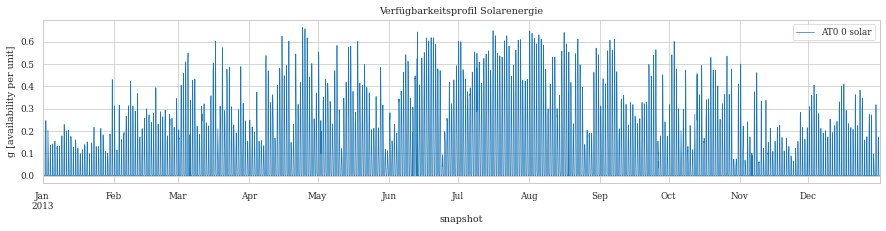

In [4]:
n.generators_t.p_max_pu.filter(like = 'AT0 0 solar').plot(figsize = (15,3), title = 'Verfügbarkeitsprofil Solarenergie')
plt.ylabel('g [availability per unit]')

An dieser Stelle fließen auch die Werte der Input-Szenarien, welche die erzeugte Menge elektrischer Energie innerhalb eines Jahres für eine bestimmte Technologie festlegen in das Modell ein. Sie werden als extra Constraints im Skript `solve_network` angeführt. Für die Erzeugungsanlagen Solar, Wind und Wasser werden pro Technologie zwei Constraints hinzugefügt, deren Funktionen im Folgenden für die Solarenergie gezeigt sind.

Für die Energiemenge, die aus dem Generator `'solar'` in Österreich stammt, wird mit der ersten Funktion ein minimaler Wert definiert, welcher in der Config-Datei in $MWh$ angegeben werden kann. Die Summe über die stündliche Leistung (lhs) wird der minimalen Energiemenge über ein Jahr (rhs) gegenübergestellt und darf diese nicht unterschreiten. Die lhs ist dabei so definiert, dass die Constraint bei höherer geographischer Auflösung gleich angewendet werden kann, weshalb im Code zwei Summen notwendig sind. Wird mit einer niedrigeren zeitlichen Auflösung modelliert muss der Wert für die minimale Erzeugung durch die zeitliche Auflösung dividiert werden. Bei einer zeitlichen Genauigkeit von 6h wäre beispielsweise in der Config-Datei für die Energiemenge `minimal_generation: solar: E[MWh]/6` anzugeben.

Die Funktion `constraint_solarMAX()` definiert die maximale Erzeugungsmenge, die gleich der minimalen Erzeugungsmenge plus 2% ist. Damit wird garantiert, dass die Erzeugungswerte, die in den zu modellierenden Szenarien angegeben sind, auf eine Genauigkeit von 2% modelliert werden. Da das gesamte Netzwerk zudem auf minimale Kosten optimiert wird und die Betriebskosten für Solar- und Windkraftwerke in der Config-Datei angepasst sind kann grundsätzlich davon ausgegangen werden, dass die Energiemenge pro Jahr mit einer höheren Genauigkeit erreicht wird. Für `minimal_generation: solar: 2.7e7` werden beispielsweise durch Solarkraftwerke in Österreich in dem Modell nach der Optimierung

In [5]:
n.generators_t.p.filter(like='AT0 0 solar').sum().sum()

27000004.806650948

MWh elektrischer Energie einberechnet. Die Eingaben für `minimal generation` in der Config-Datei sollen also genau den in einem zu modellierenden Szenario angegebenen Energiemengen entsprechen, um eine genaue Modellierung des Szenarios zu erreichen.

Für den folgenden Workflow weniger von Interesse ist die Randbedingung, die den maximalen $\text{CO}_2$ Ausstoß der Energieerzeugung festlegt. Änderungen wirken sich auf alle freien Variablen der Stromerzeugung bzw. Speicherung aus, die im Betrieb einen $\text{CO}_2$-Ausstoß aufweisen, also konventionelle Kraftwerke und Speicher.

### Optimierung nach geringsten Kosten
Der ursprüngliche Workflow von PyPSA-Eur dient dazu, die Kosten eines elektrischen Energiesystems zu minimieren. Dabei wird ein $\text{CO}_2$-Limit beachtet und Solar- bzw. Windkraftwerke entsprechend dieses Limits ausgebaut. Der Prozess der Kostenminimierung wurde aus Gründen der Einfachheit nicht umgangen, sondern ist weiterhin Teil des Workflows und wird vom Solver gemeinsam mit den in den letzten Absätzen beschriebenen Constraints und der Lösung der Matrix, welche die Netzwerkgleichungen beschreibt, durchgeführt.

### Solver
Einfache Netzwerke, wie ein auf Österreich beschränktes Netzwerk ohne weitere Vorgaben können mit frei verfügbaren Solvern gelöst werden, für das vorliegende Netzwerk wurde ein proprietärer Solver verwendet. Dabei kommen die Solver _Gurobi_ und _CPLEX_ infrage. Für die Berechnungen wurde der Gurobi-Solver verwendet. 

Die aus den Bedingungen und Netzwerkgleichungen resultierende Matrix deckt einen relativ großen Zahlenbereich ab, weshalb beispielsweise eine Anpassung der $\text{CO}_2$-Constraints an die Größenordnung der bestehenden Constraints sinnvoll ist, um das Modell numerisch stabil zu halten. Die angeführten Statistiken der Netzwerkmatrix können vom Gurobi-Solver angezeigt werden:

    Coefficient statistics:
      Matrix range     [1e-02, 3e+02]
      Objective range  [9e-03, 2e+05]
      Bounds range     [3e+00, 9e+09]
      RHS range        [5e-01, 3e+07]
      
Die großen Intervalle der "Matrix range" von $10^4$ und "RHS range" in der Größenordnung von $10^8$ zeigen die schlechte Kondition des Problems. Entsprechend ist neben der Anpassung der Solver-Variablen noch die Variable `NumericFocus = 1` im `config.yaml` File anagepasst, womit zwar die Rechenzeit erhöht wird, numerische Probleme aber vorgebeugt werden. Für den Schritt des Netzwerk lösens ist somit in etwa mit einer Rechenzeit von 3 bis 4 Stunden zu rechnen. 

## Sechster Schritt des Workflows
**Ziel dieses Schrittes:** Auswertung des elektrischen Netzwerks mit Fokus auf Zeitanalysen und Beantwortung der wissenschaftlichen Fragestellungen 

Die Auswertung dient konkret dazu, die wissenschaftliche Fragestellung der Arbeit und thematisch zusammengehörige relevante Fragestellungen zu beantworten. Die wissenschaftliche Fragestellung lautet: Welche Residuallast nicht erneuerbarer Energieerzeugung ergibt sich bei unterschiedlichen Ausbauraten fluktuierender erneuerbarer Energieträger im österreichischen Stromnetz und wie verhält sich die zeitliche Auflösung der Residuallast? Um eine grundsätzliche Beschaffenheit der nicht-erneuerbaren Residuallast beschreiben zu können stellen sich zudem noch untergeordnete Fragen:
- In welchen zeitlichen Abständen ist generell mit einem erhöhten Bedarf an nicht erneuerbarer Residuallast zu rechnen? Damit verbunden: Welche Frequenzen der Residuallast sind zu erkennen?
- Welche elektrischen Leistungsbereiche müssen wie oft durch nicht erneuerbar erzeugten Strom abgedeckt werden?
- Welche Zeitdauern der nicht-erneuerbaren Residuallast müssen überbrückt werden und zu welcher Tages- bzw. Jahreszeit sind diese Zeiten häufig?

Zur Beantwortung dieser Fragestellungen werden unter anderem die Jahresdauerlinie der Residuallast dargestellt und eine Frequenzanalyse durchgeführt.  

Zudem wird die Frage, wie sich das Angebot von Strom aus fluktuierenden erneuerbaren Quellen auf die Anforderungen an die Energieflexibilität  auswirkt behandelt. Dazu wurden folgende untergeordnete Fragestellungen formuliert:
- Welche Zeitdauern der nicht-erneuerbaren Residuallast müssen überbrückt werden und zu welcher Tages- bzw. Jahreszeit sind diese Zeiten häufig?
- Wie unterscheidet sich die Beschaffenheit vorherrschender Frequenzen der Residuallast von erkennbaren Frequenzen anderer relevanter Netzzeitreihen?
- Welche Menge an Residuallast kann durch kurzfristige Lastverschiebung mit erneuerbarer Energie gedeckt werden?
- In welcher Weise kann die Residuallast nicht erneuerbarer Energieträger als Basis für Schaltsignale möglicher Lastverschiebungspotenziale verwendet werden?
- Welche Anforderungen an die Lastverschiebungspotentiale (eg. in Plusenergiequartieren) stellen sich durch die Auswertung der Residuallast?

Um diese Fragestellungen beantworten zu können wird die Zeitreihe der Residuallast ausgewertet und Zeitdauern von Residuallast-Phasen, Anzahl an Nulldurchgängen der Residuallast sowie statistische Daten evaluiert. Zudem werden aus der Residuallast und dem zeitlichen Mittelwert dieser Schaltsignale erstellt, die als einfache Schaltsignale für Lastverschiebungspotenziale dienen können. Außerdem wird ein Skript codiert, mit dem einfache Lastverschiebungen modelliert werden und die Potentiale kurzfristiger sowie langfristiger Lastverschiebung abgeschätzt werden. 

![sechster Schritt des Workflows](Workflow(6).png)
_**Sechster Schritt des Workflows:** Analyse des Netzwerks sowie Beantwortung der wissenschaftlichen Fragestellung und thematisch damit zusammenhängender Fragestellungen, die in den blauen Ellipsen angegeben sind._

Das im vorherigen Schritt numerisch gelöste Netzwerk ist in einer netCDF-Datei gespeichert und kann in einem Python-Skript analysiert werden. Die Datei muss dafür mit `pypsa.Network("path_to_file")` importiert werden, wie dies am Anfang dieses Notebooks getan wurde. Der Pfad zur Netzwerkdatei muss dafür nicht absolut sein. Der filename muss dafür im file `config_auswertung.yaml` bei `network: filename` angegeben werden. Die mathematische Auswertung wird dabei  in erster Linie als vom restlichen Workflow getrennt behandelt. 

### Programm- Funktionen der Auswertung
In den folgenden Absätzen werden die verschiedenen Funktionen, die die mathematische Auswertung der vorhin genannten Punkte ausführen, beschrieben und an Code-Beispielen erklärt.
Voraussetzung dafür ist das Erstellen der Zeitreihe nicht-erneuerbarer Residuallast, welche am Beginn des Skripts `Netzwerkanalyse/Auswertung.py` erstellt wird. Die Residuallast besteht initial aus der Last, die nicht durch Strom erzeugt mit erneuerbaren Energieträgern in Österreich oder Strom aus Speichereinheiten in Österreich gedeckt werden kann. Zeitreihen erneuerbarer Energieträger und Speicher werden deshalb summiert und von der Zeitreihe des elektrischen Energieverbrauchs abgezogen. Dabei werden die Energieträger Solar, Wind, Run of River und Biomasse als erneuerbare Erzeugungsanlagen gezählt, Speicherwasserkraftwerke und Pumpspeicherkraftwerke zählen wie Batteriespeicher und Wasserstoffspeicher zu den Speichereinheiten.

In [6]:
renewables = ['solar', 'wind', 'ror', 'biomass']
stores = ['H2O', 'battery']
store_units = ['PHS', 'hydro']
load = n.loads_t.p.filter(like='AT')
renload = n.generators_t.p.filter(like = 'geothermal').filter(like = 'AT').sum(axis=1)
for x in renewables: 
    renload += n.generators_t.p.filter(like = x).filter(like = 'AT').sum(axis=1)
for x in stores:
    renload += n.stores_t.p.filter(like=x).filter(like='AT').sum(axis=1)
for x in store_units:
    renload += n.storage_units_t.p.filter(like=x).filter(like='AT').sum(axis=1)
renload[renload<0]=0
renload = renload.to_frame(name = 'AT0 0')
res = load.values - renload ###Zeile wurde fürs notebook angepasst!

Aufgrund der unterschiedlichen Modellierung der Speichereinheiten von Wasserspeicherkraftwerken und Pumpspeicherkraftwerken zu Batteriespeicher- bzw. Wasserstoffspeicheranlagen muss hier zwischen `stores` und `stores_units` unterschieden werden.

Das weitere Skript `Auswertung.py` ist in die Bereiche _Basic_Data_, _Residual_load_, _Nulldurchgang_, _Jahresdauerlinie_, _Zeitdauern_, _Lastverschiebungssimulation_, _Frequenzanalyse_ und _Schaltsignale_ geteilt. Dabei besteht jeder Teil aus den Funktionen, welche die Auswertung bzw. Bearbeitung der Daten durchführen und einer Funktion, durch die die bearbeiteten Daten entsprechend graphisch aufbereitet bzw. gespeichert werden. Die Funktionen rufen sich dabei selbst auf und die Eingabe, welche thematischen Bereiche ausgewertet werden sollen kann im `config_auswertung.yaml` file durch Eingabe von `true` oder `false` (bzw. allgemein 'not true') getroffen werden.

Die Ergebnisse werden dann in mehrfacher Form ausgegeben. Zum Einen wird ein Ordner mit Plots erstellt, welcher alle grafischen Aufbereitungen enthält, zum Anderen werden alle relevanten Outputs als csv-Datei gespeichert. Zusätzlich gibt es ein Excel-File, das die Ergebnisse auf mehreren Tabellenblättern enthält. Dieses wird, genauso wie die csv-Dateien, im Ordner _result_files_ gespeichert.

#### Basic Data
_Speicherort der Ausgaben:_
- Plots/Basic_Data
- Zusammenfassung Netzwerk.txt

Es werden die Zeitreihen der Erzeugung erneuerbarer elektrischer Energie in Österreich und der elektrischen Last in Österreich geplottet. Ebenso werden die Stromerzeugungstechnologien nach installierter Leistung und Stromerzeugung innerhalb eines Jahres aufgelistet. Dies kann beispielsweise als erster Check verwendet werden, in welcher Genauigkeit das gewünschte Szenario modelliert werden konnte. Die Daten werden dafür direkt aus den Pandas-Dataframes bzw. Dictionarys der importierten nc-Datei verwendet, werden in `['solar','wind','ROR','coal','gas','rest']` gruppiert und direkt geplottet bzw. in der Datei `Zusammenfassung Netzwerk.txt` gespeichert.

#### Residuallast

_Speicherort der Ausgaben:_
- Plots/Residuallast
- RES_pro_Monat.csv
- RES_pro_Tag.csv
- RES_pro_Stunde.csv
- RL_nach_Tageszeit_pro_Monat.csv

_ungefährer Ort im Skript:_  210 - 350

Die Auswertung der Residuallast findet auf unterschiedlichen zeitlichen Skalen statt. Die Funktionen `Residuallast_per_hour(jahr, res)`, `Residuallast_per_day(jahr,silvester,pres,einjahr)` und `Residuallast_per_month` werten die Residuallast auf einer stündlichen, einer 24-stündlichen und einer monatlichen Genauigkeit aus. Dabei wird für die langfristige Auswertung die Leistung der stündlichen Residuallast über 24 Stunden oder über $720 \pm 24$ Stunden (abhängig davon, wie viele Tage das jeweilige Monat hat) summiert. Die stündlichen Daten werden direkt aus dem nc-File exportiert, für die Gruppierung der Last nach Tagen wird eine for-Schleife verwendet, die jeweils über einen Tag läuft. Die Gruppierung der Residuallast nach Monat kann mit der pandas-funktion `df.groupby(index)` durchgeführt werden. Grafisch aufbereitet werden die Ergebnisse von der Funktion `plot_Residuallast(counts,zeitraum,einheit)`, die sich im Skript am Ende des Abschnittes "Residuallast" befindet.

Für eine Analyse der tages- und jahreszeitlichen Schwankungen der Residuallast werden monatlich die Residuallast-Zeiten ausgewertet. Dabei wird auf die Auswertung der Leistung der Last verzichtet. Es wird an jedem Tag $d$ in einem Monat $m$ unterschieden, ob zum jeweiligen Tageszeitpunkt $t$ auf nicht-erneuerbare Residuallast zurückgegriffen wird, oder nicht. Die Variable $x_t$ für einen bestimmten Tag $d$ eines Monats $m$ ergibt sich dann aus
$$
x_{m,d,t} = \begin{cases}
1 \text{ if Residuallast} > 0\\
0 \text{ if Residuallast} \leq 0\\
\end{cases}
$$
Der angeführte Code, welcher im Skript in der Funktion `Residuallast_yn_per_day_per_hour(res,jahr)` gespeichert ist summiert über alle Tage eines Monats, damit das Ergebnis die Anzahl der Tage in einem Monat darstellt, an denen zu dieser Uhrzeit auf nicht-erneuerbare Residuallast zurückgegriffen wird. Jeder Eintrag $x_{m,t}$ der resultierenden Matrix $X^{monate \times stunden} = X^{12 \times 24}$ wird also durch 
$$
x_{m,t} = \sum_{d} x_{m,d,t} \quad \text{mit} \nobreakspace m \in [0,11]  \text{,} \nobreakspace t \in [0,23]
$$
erstellt. Das Ergebnis der Funktion, $X$, ist hier zu sehen. Dafür wurde der Code der Funktion leicht verändert, um im Notebook ein Ergebnis anzuzeigen. Alle eingefügten Commands sind extra gekennzeichnet.

In [7]:
### Begin
monate = np.linspace(0,8760, 13, dtype = int, endpoint = False)
months = ['Jänner', 'Februar', 'März', 'April', 'Mai', 'Juni', 'Juli', 'August', 'September', 'Oktober', 'November', 'Dezember']
### End: Zeilen wurden fürs Notebook eingefügt
nach_monat_zeit = [[0] * 24, [0] * 24, [0] * 24, [0] * 24, [0] * 24, [0] * 24, [0] * 24, [0] * 24, [0] * 24, [0] * 24, [0] * 24, [0] * 24]
for v in range(1, res.size):
    if (res['AT0 0'].iloc[v] > 0):
        point=res.index[v]
        for i in range(0, len(nach_monat_zeit)):
            if (v >= monate[i] and v < monate[i+1]):
                for ask_run in range(0,24):
                    if ask_run == point.hour:
                        nach_monat_zeit[i][ask_run] += 1
frame = pd.DataFrame(nach_monat_zeit, columns= range(0,24), index = months)
frame ### Zeile fürs Notebook hinzugefügt

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Jänner,19,18,19,20,22,24,24,25,21,21,...,21,26,25,24,23,19,16,19,18,20
Februar,18,20,21,20,22,24,23,21,19,20,...,20,25,26,26,24,22,22,23,19,19
März,18,19,18,18,19,21,21,19,18,16,...,18,19,22,23,22,18,18,18,19,19
April,19,19,18,21,22,23,24,24,19,19,...,21,23,18,16,14,14,14,15,17,18
Mai,7,6,7,7,7,7,12,9,6,5,...,8,10,9,6,5,5,4,5,6,6
Juni,10,10,10,10,11,12,12,11,4,5,...,11,13,10,10,10,11,10,11,11,10
Juli,8,7,7,7,9,7,12,13,9,5,...,11,16,10,9,7,7,6,6,6,7
August,5,5,7,6,11,9,10,13,10,4,...,14,14,7,4,5,5,5,4,6,5
September,9,8,8,8,11,14,12,18,12,10,...,21,18,10,8,8,8,9,9,9,9
Oktober,14,14,13,12,14,18,13,15,14,12,...,17,14,15,17,12,12,12,12,13,13


Weiters sind im Abschnitt "Residual load" die Funktionen `count_per_month(v,df)`, `ND_und_Res_per_month_per_hour()` und `plot_ND_und_RES_mh(monat, df, df)` zu finden. Diese Auswertungen dienen ebenfalls der Beantwortung der Fragestellung, wie die Residuallast grundsätzlich beschaffen ist und zu welchen Zeiten vermehrt auf nicht-erneuerbare Residuallast zurückgegriffen wird.

Während eine reine Auswertung des Wertes der Residuallast nur zeigt, zu welchen Zeiten nicht-erneuerbarer Strom verwendet wird, kann weiters durch Analyse der Nulldurchgänge darauf geschlossen werden, zu welchen (Tages-)zeiten die erzeugte Leistung aus erneuerbaren Quellen nicht mehr ausreicht, um die elektrische Last zu decken. Ein Nulldurchgang zum Zeitpunkt $t$ zeichnet sich dabei dadurch aus, dass der Wert der Residuallast zum Zeitpunkt $t-1$ negativ und zum Zeitpunkt $t$ positiv ist. Durch die gemeinsame Darstellung dieses Wertes mit der Residuallast in derselben Berechnungsweise, wie sie für die vorherige Funktion `Residuallast_yn_per_day_per_hour()` erklärt wurde, kann ein umfassenderer Überblick über die zeitlichen Unterschiede der Notwendigkeit nicht-erneuerbarer Residuallast verschaffen werden.

Implementiert ist das mithilfe von zwei Datenframes, was die Datenspeicherung einfacher macht. In der Funktion `ND_und_Res_per_month_per_hour()`, welche hier der Einfachheit halber nicht als Funktion definiert ist, werden die Zeitpunkte eines Nulldurchgangs bzw. einer positiven Residuallast gefiltert. Die Funktion `count_per_month(v,df)` ordnet die Zeitpunkte nach dem Monat und dem Tageszeitpunkt und retourniert das Datenframe, welches sich mit jedem Durchlauf der for-Schleife der Hauptfunktion füllt. Die grafische Aufbereitung der Ergebnisse wird durch die Funktion `plot_ND_und_RES_mh(monat, df, df)` durchgeführt, welche unverändert aus dem Skript entnommen wurde.

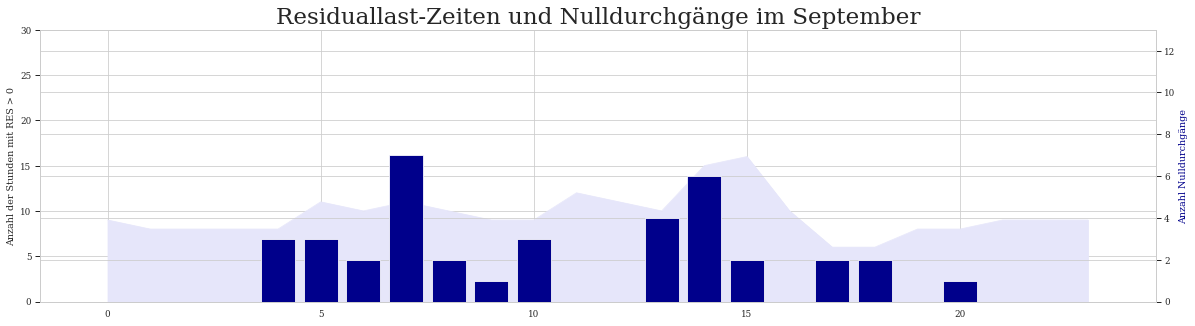

In [8]:
def count_per_month(v, nach_monat_zeit):
    point = res.index[v]
    for i in range(0, len(nach_monat_zeit)):
        if (v >= monate[i] and v < monate[i+1]):
            for ask_run in range(0, 24):
                if ask_run == point.hour:
                    nach_monat_zeit[i][ask_run] +=1
    return(nach_monat_zeit)
def plot_ND_und_RES_mh(monat, ND_frame, RES_frame):
    fig,ax = plt.subplots(figsize=(20,5))
    title2 = ' '
    if monat != 'nan':
    	title2 = (' im ' + monat)
    plt.title('Residuallast-Zeiten und Nulldurchgänge' + title2, fontsize = 23)
    ax.plot(range(0, 24),
    		RES_frame.loc[monat],
    		color = 'lavender')
    ax.set_ylabel('Anzahl der Stunden mit RES > 0')
    plt.ylim([0,30])
    plt.fill_between(range(0,24), RES_frame.loc[monat],
    		color = 'lavender')
    ax2 = ax.twinx()
    ax2.bar(range(0,24), 
    		ND_frame.loc[monat],
    		color = 'darkblue')
    ax2.set_ylabel('Anzahl Nulldurchgänge', color = 'darkblue')
    plt.ylim([0,13])

ND_nmz = [[0]*24,[0]*24,[0]*24,[0]*24,[0]*24,[0]*24,[0]*24,[0]*24,[0]*24,[0]*24,[0]*24,[0]*24]
RES_nmz = [[0]*24,[0]*24,[0]*24,[0]*24,[0]*24,[0]*24,[0]*24,[0]*24,[0]*24,[0]*24,[0]*24,[0]*24]
for v in range(1, res.size):
    if (res['AT0 0'].iloc[v-1] < 0 and res['AT0 0'].iloc[v] > 0):
        ND_nmz = count_per_month(v, ND_nmz)
    elif(res['AT0 0'].iloc[v] > 0):
        RES_nmz = count_per_month(v, RES_nmz)
ND_frame = pd.DataFrame(ND_nmz, columns = range(0,24), index = months)
RES_frame = pd.DataFrame(RES_nmz, columns = range(0,24), index = months)
plot_ND_und_RES_mh('September', ND_frame, RES_frame) #code fürs Notebook verändert
# die erste Variable (jetzt 'September') kann verändert werden, um Ergebnisse anderer Monate zu erhalten

Der Parameter "Nulldurchgang" wird auch für weitere Analysen herangezogen, die im folgenden Abschnitt erläutert werden. 

#### Nulldurchgang
_Speicherort der Ausgaben:_
- Plots/Nulldurchgang
- ND_per_day.csv
- ND_per-day_nach_Monat.csv

_ungefährer Ort im Skript:_ 350 - 420

Neben dem Zeitpunkt der Nulldurchgänge der Residuallast ist auch die Anzahl der Nulldurchgänge in einem bestimmten Intervall interessant zu analysieren. Sie geben Aufschluss darauf, wie stabil Phasen positiver bzw. negativer Residuallast sind. Daraus ist abzuleiten, welche zeitliche Flexibilität Lastverschiebungspotenziale aufweisen müssen, um Lasten, die in dem Modell nicht-erneuerbar gedeckt werden effizient verschieben zu können.

Die Funktion der Residuallast wird in den Skripten auf Nulldurchgänge, also wenn gilt, dass $f(t-1) < 0 \nobreakspace \text{and} \nobreakspace f(t) \geq 0$, untersucht und die Nulldurchgänge pro Tag gezählt. Zudem wird in der Funktion `Nulldurchgang_per_month` die durchschnittliche Anzahl an Nulldurchgängen an einem Tag pro Monat ausgegeben. Die Ergebnisse werden grafisch mit einer eigenen Funktion aufbereitet und als csv-Datei gespeichert.

#### Jahresdauerlinie

_Speicherort der Ausgaben:_
- Plots/Jahresdauerlinie
- JDL - erzeugung erneuerbarer Energie.csv
- JDL - negativen Residuallast.csv
- JDL - positiven Residuallast.csv
- JDL - Residuallast.csv

_ungefährer Ort im Skript:_  420 - 450

Die Darstellung der Jahresdauerlinie eignet sich, um die Last mit den Zeiträumen in Verbindung zu interpretieren und abschätzen zu können, wie viel Energie in welchen Zeiträumen fließt. Der Fokus der Arbeit liegt auf der zeitlichen Auswertung der Daten, es ist aber wichtig, die Komponente der Leistung ebenfalls in die Betrachtungen einfließen zu lassen.

Die Funktion `Jahresdauerlinie(frame, art)`, welche die Jahresdauerlinie erstellt kann für unterschiedliche Größen aufgerufen werden. Die diskreten Werte der übergebenen Frames werden nach Wert geordnet, graphisch aufbereitet und als Grafik und csv-Datei gespeichert. Der Code zeigt die Funktion und ein Beispiel der Jahresdauerlinie der Residuallast.

/home/max/anaconda3/envs/pypsa-eur/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1358: UserWarning:

Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.



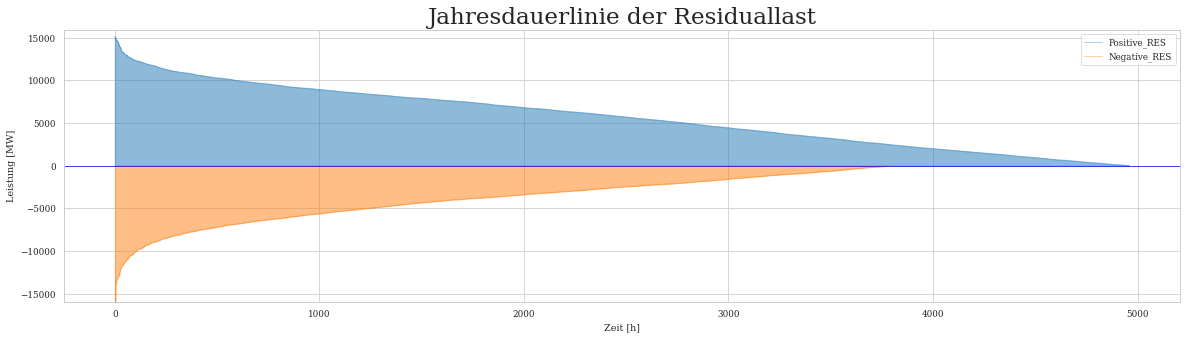

In [9]:
def Jahresdauerlinie(frame, art):
    sort = frame.sort_values(by = 'AT0 0',
                             ascending = False,
                             ignore_index = True)
    sorted_lists = [sort]
    name_list = [art]
    for i in range(0, sort.index.size): # wenn werte negativ werden, dann sort dort teilen
        if sort['AT0 0'].iloc[i] < 0:
            sort_pos = sort[0:i]
            sort_neg = sort[i:sort.index.size].sort_values(by = 'AT0 0',
                                                          ascending = True,
                                                          ignore_index = True)
            sorted_lists=[sort_pos, sort_neg]
            name_list = ['Positive_RES', 'Negative_RES']
            break
    fig,ax = plt.subplots(figsize=(20,5))
    for v in sorted_lists:
        v.plot(kind = 'area', stacked = False,
                    ylabel = 'Leistung [MW]',
                    xlabel = 'Zeit [h]',
                    ax=ax,
                    sharey = True, sharex = True)
        plt.legend(name_list)
    plt.title('Jahresdauerlinie der ' + art, fontsize = 23)
    plt.axhline(y = 0, c = 'blue')
    ax.set_ylim([-sorted_lists[0]['AT0 0'].max()*1.05,sorted_lists[0]['AT0 0'].max()*1.05])
# der restliche Teil der Funktion wurde für das Notebook weggelassen
Jahresdauerlinie(res, 'Residuallast')

Leider gibt die grafische Darstellung der Funktion einen UserWarning aus. Dieser entsteht vermutlich daraus, dass eine nicht-diskrete Plotting-Methode auf diskrete Werte angewendet wird. Für die grafische Aufbereitung der Jahresdauerlinie ist eine kontinuierliche Generalisierung ausreichend und numerisch deutlich weniger aufwendig. Die Warnung kann mit Änderung der Plotting-Methode auf 'line' vermieden werden, die grafische Aufbereitung ist aber damit weniger deutlich.

#### Zeitdauern einer Residuallast-Phase
_Speicherort der Ausgaben:_
- Plots/Zeitdauern
- ZD - RES negativ.csv
- ZD - RES positiv.csv

_Ungefährer Ort im Skript:_  450 - 500

Neben der Anzahl der Nulldurchgänge, welche beschreiben, wie oft innerhalb eines bestimmten Intervalls eine Phase anfängt, in der die Last nicht mit erneuerbarer Energie gedeckt werden kann, ist die Zeitdauer einer Phase nicht-erneuerbarer Energie-Deckung ebenfalls von Interesse um auf Anforderungen an Lastverschiebungspotenziale schließen zu können. Auf der anderen Seite sind Zeiten negativer Residuallast, also wenn mehr erneuerbare Energie erzeugt wird, als von den aktuellen Lastkurven verlangt ein genauso wichtiger Faktor, der Anforderungen an Lastverschiebungspotenziale stellt.

Technisch ist diese Analyse mit drei Funktionen implementiert. Das hat vor allem den Grund, dass diese leicht einzeln mit verschiedenen Parametern aufgerufen werden können. Der Code, der hier für die positive Residuallast gezeigt ist, funktioniert für negative Residuallast-Zeiten in gleicher Art mit leicht geänderten Zeilen, die im Code markiert sind. Die Funktionen `ZR_RES(res)` bzw. `ZR_EE(res)` werten die Zeitdauern einer zeitlichen Phase aus und übergeben die Ergebnisse an die Funktion `build_dataframe(dauer, RES)`. Diese bestimmt zuerst die Länge des Datenframes. Da selten sehr lange durchgängige Residuallast-Phasen vorkommen wird bestimmt, welcher Anteil der Phasen nicht mehr in die grafische Aufbereitung mit einfließt. Dazu werden von der längsten Residuallast-Phase angefangen Phasen, alle Phasen, die gemeinsam weniger als 20 mal im Jahr vorkommen vom Datenframe abgeschnitten und der Rest geplottet. Das gesamte Datenframe wird in den csv-Dateien gespeichert. Der Anteil nicht geplotteter Phasen kann in der im Code markierten Zeile geändert werden.

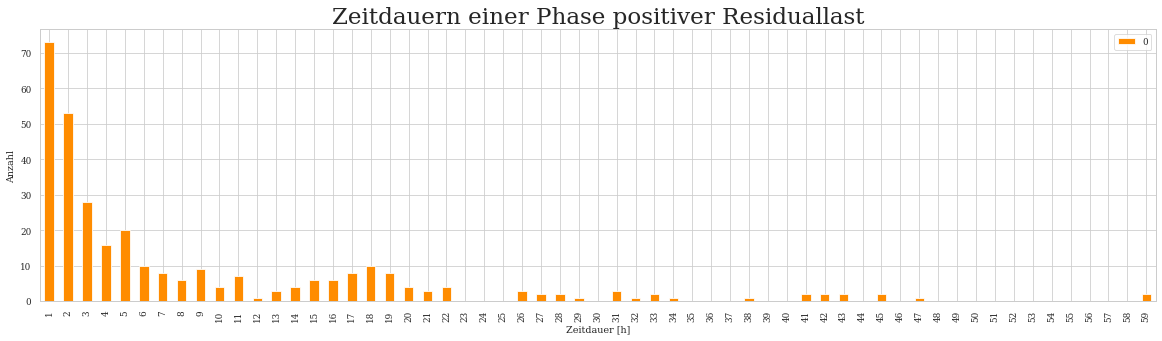

In [10]:
def build_dataframe(dauer, RES):
    summe = 0
    run = len(dauer)-1
    while run > 0:
    	summe += dauer[run]
    	if summe > 20: ### Anzahl der Phasen, die nicht geplottet werden! 
    		break
    	run -= 1
    frame = pd.DataFrame(dauer[1:run+1])
    frame.index = np.arange(1, len(frame)+1)
    frame.plot(kind = 'bar', figsize = (20,5),
    			ylabel = 'Anzahl',
    			xlabel = 'Zeitdauer [h]',
    			color = 'darkorange')
    plt.title('Zeitdauern einer Phase ' + RES + 'er Residuallast', fontsize = 23)
## Rest der Funktion fürs Notebook weggelassen

dauer = np.zeros(300)
end = 0
begin = 0
for v in range(0, res.size):
    if res['AT0 0'].iloc[v-1] < 0 and res['AT0 0'].iloc[v] >= 0: #### Änderung EE <=> RES
        if v - end > 1:
            dauer[end-begin] +=1
            begin = v
        for w in range(v, res.size):
            if res['AT0 0'].iloc[w] < 0: #### Änderung EE <=> RES
                end = w
                break
build_dataframe(dauer, 'positiv')

Eine Phase positiver Residuallast ist im Intervall $[t_1, t_2]$, wenn für die Residuallast $P_{RES}$ gilt: 

$$\\ P_{RES}(t_1-1) < 0 \nobreakspace \text{and} \nobreakspace P_{RES}(t_1) \geq 0\\
P_{RES}(t_2-1) \geq 0 \nobreakspace \text{and} \nobreakspace P_{RES}(t_2) < 0\\ $$
. Dabei wird durch jeden Nulldurchgang eine neue Zähleinheit positiver bzw. negativer Residuallast begonnen. Betrachtet man beispielsweise die positive Residuallast, kann es auch sinnvoll sein, kurze Phasen negativer Residuallast in eine Zähleinheit positiver Residuallast mit einzuschließen. Dies ist im jetzigen Stand noch nicht implementiert.

#### Frequenzanalyse

_Speicherort der Ausgaben:_

- Plot/Frequenzanalyse
- Frequenzen_Erzeugung erneuerbarer Energie.csv
- Frequenzen_Last.csv
- Frequenzen_Residuallast.csv

_Ungefährer Ort im Skript:_  580 - 640

Durch eine Analyse der vorherrschenden Frequenzen kann die Regelmäßigkeit der Notwendigkeit nicht erneuerbarer Residuallast untersucht werden. Durch den Vergleich mit den vorherrschenden Frequenzen anderer Netzgrößen können Lastverschiebungspotenziale zeitlich gruppiert werden. Mithilfe einer Fast-Fourier-Transformation werden die Frequenzen der Zeitfunktionen in der Funktion `fourier(data, data_type)` extrahiert. Die Funktion `find_maxima(df)` vereinfacht die Auswertung durch Markierung der lokalen Maxima. Aufgrund der Unregelmäßigkeit der resultierenden Funktionen werden lokale Maxima unterschiedlich gut erkannt. Durch Anpassung der Parameter, die im Code entsprechend gekennzeichnet sind kann die Präzision der Funktion verändert werden. 

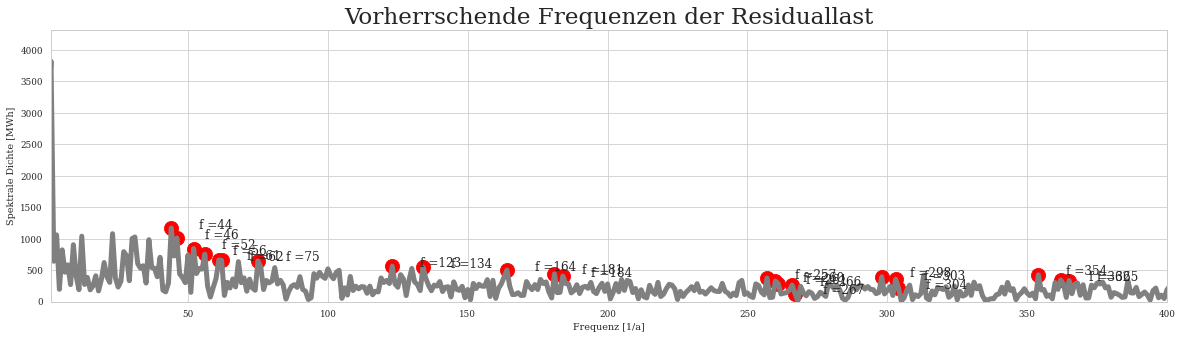

In [11]:
def fourier(data, data_type):
    N = data.index.size
    T = 1/8760 #restriction
    x = np.linspace(0.0, N*T, N, endpoint = False)
    y = data['AT0 0']
    yf = np.fft.fft(y) #fourier transform
    xf = fftfreq(N, T)[:N//2] #sample frequencies
    df = pd.DataFrame(data = (2.0/N * np.abs(yf[0:N//2])), index = xf, columns = ['f'])
    df = find_maxima(df)
    plot_fourier(df, data_type)
def find_maxima(df):
    delT = 2 ##Anpassung der Parameter
    scalV = 0.5 ##Anpassung der Parameter
    break_point = (df['f'][10:365].max() * 3.3) / (df['f'][10:365].mean() * 1) ## Anpassung der Parameter
    df['max'] = np.nan
    for v in range(10, 365):
        if df['f'][v] > break_point:
            for w in range(v, df['f'].size):
                if df['f'][w] < break_point:
                    maxindex = df['f'][v:w].idxmax()
                    maxvalue = df['f'][v:w].max()
                    if ((df['f'][maxindex-delT] * scalV < maxvalue) & (df['f'][maxindex+delT] * scalV < maxvalue)):
                        df['max'][maxindex] = maxvalue
                    break
    return(df)
def plot_fourier(df, name):
    df['f'].plot(linewidth = 5,
      figsize = (20,5),
      color = 'grey')
    for v in range(0, 366):
        if not math.isnan(df['max'][v]):
            plt.text(x = v+10, y = df['max'][v], s = ('f =' + str(v)), fontsize = 12)
    plt.scatter(x = df.index, y = df['max'], color = 'r', s = 200)
    plt.xlim(1, 400)
    plt.ylim(0, df['f'][1:365].max() + 5e+2)
    plt.xlabel('Frequenz [1/a]')
    plt.ylabel('Spektrale Dichte [MWh]')
    plt.yscale('linear')
    plt.title('Vorherrschende Frequenzen der ' + name, fontsize = 23)
fourier(res,'Residuallast')

Entsprechend der allgemeinen Ordnung des Skripts gibt es auch hier wieder eine Funktion `plot_fourier(df, name)`, welche die Ergebnisse entsprechend grafisch aufbereitet. Die Funktion `fourier(data, data_type)` kann für alle Zeitreihen, die mit einer zeitlichen Genauigkeit von einer Stunde für ein Jahr vorliegen, aufgerufen werden. Hier wurde die Funktion beispielhaft für die Residuallast aufgerufen, das Ergebnis ist aber ohne Vergleich mit anderen Größen wenig aussagekräftig.

#### Einfache Lastverschiebungssimulation

_Speicherort der Ausgaben:_
- Plots/Lastverschiebung
- Lastverschiebung_einfach.csv

_Ungefährer Ort im Skript:_  500 - 580

Zur Beantwortung der Fragestellung, welche Menge nicht erneuerbarer Residuallast durch kurzfristige Lastverschiebung vermieden werden kann wird eine einfache Lastverschiebungssimulation durchgeführt. Daraus können im Weiteren die Anforderungen an Lastverschiebungspotenziale abgeleitet werden, die für kurzfristige Lastverschiebung und Vermeidung nicht erneuerbarer Residuallast eingesetzt werden sollen. 

Die Simulation beruht auf dem Ansatz, dass die elektrische Leistung keinen limitierenden Faktor darstellt. Elektrische Verbraucher, die mögliche Lastverschiebungspotenziale darstellen können also beliebig große Leistungen verschieben. Diese können aber nur über begrenzte Zeiträume verschoben werden. Konkret wird die summierte Energie einer Phase negativer Residuallast auf den darauf folgenden Zeitraum positiver Residuallast übertragen und die Energiemengen voneinander abgezogen. 
Schematisch ist das in folgender Abbildung zu sehen:

![Schema Lastverschiebung](Lastverschiebungspotentiale.png)

Eine Phase der Lastverschiebung ist durch Beginn des grünen Bereiches bis zum Ende des orangen Bereiches gekennzeichnet. Die grüne Fläche wird dabei auf die orange übertragen und die beiden werden voneinander abgezogen.

Die kurzfristig verschiebbare Energie wird folglich berechnet: 

$E_i = E_{RES, i} - E_{EE, i} \quad \text{mit} \begin{cases}
E_{EE,i} = \sum_l P_l, \quad l \in [i,j]\\
E_{RES,i} = \sum_l P_l, \quad l \in [j, i+1]\quad j \in (i, i+1)
\end{cases}$

Um eine konsistente und damit leichter interpretierbare Darstellung der Ergebnisse zu erreichen wird die Leistung für eine Zeitdauer der Lastverschiebung durch

$$P_i = \frac{E_i}{t_{i+1} - t_i}$$

berechnet. Dabei wird jeweils die Zeitdauer von einem Nulldurchgang bis zum folgenden Nulldurchgang gleicher Richtung herangezogen. Damit ist die verschobene Energie wieder durch das Integral der Funktion gegeben und die Leistung direkt ablesbar. Energie, die innerhalb einer solchen Phase nicht verschoben werden kann, weil Last nicht gedeckt werden kann oder die verschiebbare erneuerbar erzeugte Energie mit den modellierten Lastkurven nicht verbraucht wird ist demnach langristig zu speichernde Energie. 

Im Skript ist dies durch eine Funktion implementiert. Die Summierung der Leistung positiver sowie negativer Residuallast wird durch eine eigene Funktion übernommen. Wichtig ist, dass der Eintrag ins Datenframe `df2` und damit ins Datenframe `allframe` nach der ersten IF-Abfrage durchgeführt wird, damit in einer Datenzeile immer die negative Residuallast mit der darauf folgenden Energiemenge der positiven Residuallast befindet. Alle relevanten Ergebnisse und Zwischenergebnisse, die in dem datenframe `allframe` gespeichert sind, sind in der Datei `Lastverschiebung_einfach.csv` zu finden. 

In [12]:
def count_power(begin, end):
    sum = 0
    for i in range(begin, end):
        sum += res['AT0 0'].iloc[i]
    return sum

v=0
lastv = 0
w=0
RES=0
EE=0    
cols = ['Anfang', 'Ende', 'RES', 'EE', 'Wechsel_EE-RES']
allframe = pd.DataFrame(columns=cols)
for v in range(1, res.size):
	if (res['AT0 0'].iloc[v-1] > 0 and res['AT0 0'].iloc[v] <= 0):
		RES = count_power(w,v)
		df2 = pd.DataFrame([[lastv, v, RES, EE, w]], columns = cols)
		for w in range(v, res.size):
			if res['AT0 0'].iloc[w-1] <= 0 and res['AT0 0'].iloc[w] > 0:
				EE = count_power(v,w)
				allframe = allframe.append(df2, ignore_index = True)
				lastv = v
				break
allframe['Delta_t'] = allframe ['Ende'] - allframe['Anfang']
allframe['Delta_E'] = allframe['RES'] + allframe['EE']
LVp = [0] * allframe.index.size # variablen erst jetzt definieren, wo klar ist, wie lange das df ist
LVl = [0] * allframe.index.size
P_kurz = [0] * allframe.index.size
P_lang = [0] * allframe.index.size
for i in range(0,allframe.index.size):
    res = allframe['RES'].iloc[i]
    ee = allframe['EE'].iloc[i]
    t = allframe['Delta_t'].iloc[i]
    LVp[i] = min([res,ee], key = abs)
    LVl[i] = max([res, ee], key = abs) - LVp[i]
    LVp[i] = abs(LVp[i])
    P_kurz[i] = LVp[i] / t
    P_lang[i] = LVl[i] / t
allframe['LV_kurz'] = LVp
allframe['LV_lang'] = LVl
allframe['P_kurz'] = P_kurz
allframe['P_lang'] = P_lang
allframe['Anteil_kurz'] = abs(allframe['LV_kurz'] / (allframe['LV_kurz'] + abs(allframe['LV_lang'])))
allframe['Anteil_lang'] = abs(allframe['LV_lang'] / (allframe['LV_kurz'] + abs(allframe['LV_lang'])))
    # der restliche Code wurde fürs Notebook weggelassen

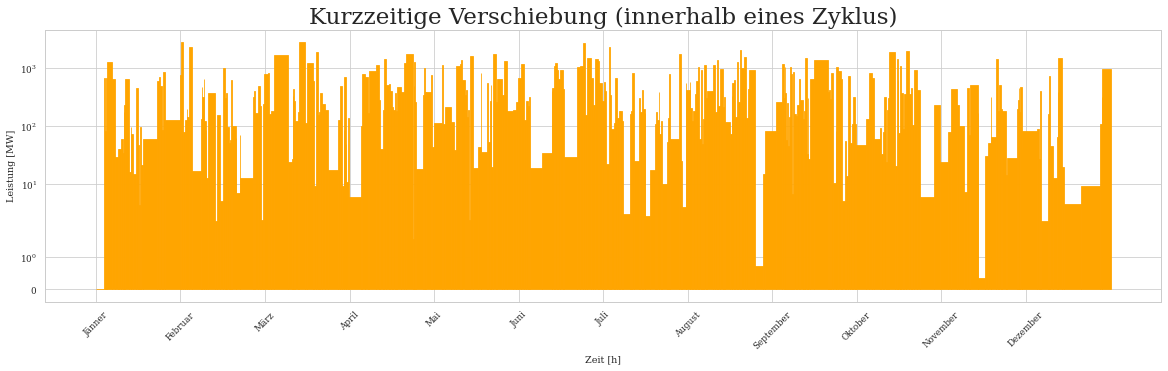

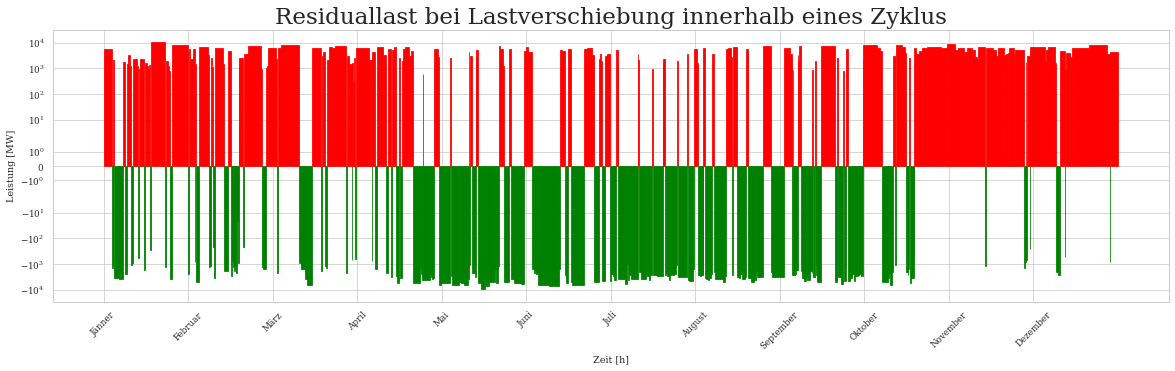

In [13]:
def plot_Lastverschiebung(beschreibung, dauer, power, start, end):
    color = 'orange' if beschreibung == 'Kurzzeitige Verschiebung (innerhalb eines Zyklus)' else 'red'
    	
    fig,ax = plt.subplots(figsize=(20,5))
    ax.plot([0,100],[0,100], linewidth = 0.0003) #to get plot
    ax.set_yscale('symlog')
    for v in range(0, power.size):
    	if color != 'orange':
            color = 'green' if power[v] < 0 else 'red'
    	ax.add_patch(Rectangle((start[v],0),
    			width = dauer[v],
    			height = power[v],
    			color = color))
    plt.title(beschreibung, fontsize = 23)
    xt = []
    for i in range(0, 12):
        xt.append(int(i/12 * end[end.size-1]))
    ax.set_xticks(xt)
    ax.set_xticklabels(months, minor = False, rotation = 45)
    plt.xlabel('Zeit [h]')
    plt.ylabel('Leistung [MW]')
plot_Lastverschiebung('Kurzzeitige Verschiebung (innerhalb eines Zyklus)', allframe['Delta_t'], allframe['P_kurz'], allframe['Anfang'], allframe['Ende'])
plot_Lastverschiebung('Residuallast bei Lastverschiebung innerhalb eines Zyklus', allframe['Delta_t'], allframe['P_lang'], allframe['Anfang'], allframe['Ende'])

Die Plots stellen die einfache und anschauliche Darstellung der Ergebnisse dar. Technisch gesehen bestehen sie aus verschiedenen Rechtecken, die als horizontale Länge jeweils die Zeitdauer einer Lastverschiebungs-Phase, also $\Delta t = t_{i+1}-t_i$, haben und deren vertikale Länge der durchschnittlichen Leistung $P_i$ einer Phase entspricht. Die Skala ist logarithmisch gewählt.

#### Erstellen von Schaltsignalen

_Speicherort der Ausgaben:_
- Plots/Schaltsignale
- Schaltsignale_RES1.csv
- Schaltsignale_RES2.csv
- Schaltsignale_RES3.csv

_ungefährer Ort im Skript:_  640 - 750

Für die folgenden Schaltsignale wird die Residuallast nicht erneuerbarer Energie als Basis herangezogen. Durch unterschiedliche Verarbeitung ergeben sich verschiedene Schaltsignale für Lastverschiebungspotenziale. Sie sollen angeben, zu welchen Zeitpunkten Lasten, die zeitlich verschoben werden können, mit elektrischer Energie versorgt werden sollen, und zu welchen Zeitpunkten der Einsatz dieser elektrischen Verbraucher nicht günstig ist. Mit den folgenden Skripten werden durch unterschiedliche Algorithmen binäre Signale erstellt. Ramps werden dabei nicht betrachtet. Eine tragende Rolle spielt dabei der laufende Mittelwert. Dieser wird in der Funktion `mean_calcs(signaldf)` auf unterschiedliche Arten berechnet. Dabei sind die Berechnungsmethoden immer linear, also alle betrachteten Einträge der Funktion fließen gleich stark in die Berechnung des Mittelwerts ein. Zudem wird der Wert zentriert berechnet, was bedeutet, dass wenn $n$ Einträge in die Berechnung einfließen für die Berechnung des i-ten Wertes der Zeitreihe die Einträge $j \in [i-n/2, i+n/2]$ betrachtet werden. Der laufende Mittelwert wird für $n = 5$ genauso wie für $n = 24$ einbezogene Einträge berechnet. Die Werte für $n$ kamen durch Analyse der Ergebnisse der Zeitdauern negativer und positiver Residuallast zustande, genauso wie durch Ausprobieren an verschiedenen Signalen.

##### Signal 1
Das Schaltsignal wird rein durch den laufenden Mittelwert bestimmt. Ist dieser negativ, wird ein positives Schaltsignal ausgesendet (`1`), ist der Mittelwert negativ, so wird ein negatives Schaltsignal ausgesendet (`0`). Der Vergleich findet durch die eigene Funktion `compare(mean,res,i,comparison)` statt, welche jeweils die nächsten $n$ Werte in den Vergleich mit einbeziehen kann. Die folgende Darstellung zeigt den Algorithmus, aus dem das Schaltsignal entspringt und der im darauf folgenden Code in der funktion `ressignal1(signaldf)` implementiert ist. 

![Schaltsignal 1](RES1-Algorithmus.png)

In [14]:
def compare(mean, res, i, comparison): 
    n = 2 # Anzahl an Stunden, die zusammen betrachtet werden sollen
    found = False
    ops = {'>' : operator.gt, '<' : operator.lt, '==' : operator.eq}
    if i+n >= signaldf.index.size:
        i = signaldf.index.size-n
    for j in range(i, i+n):
        if not ops[comparison](mean[j], res[j]):
            found = True
        return not found
def mean_calcs(signaldf):
    n = 5
    signaldf['mean'] = signaldf['Residuallast'].rolling(n).mean().shift(-int(n/2))
    m = 24
    signaldf['mean_24h'] = signaldf['Residuallast'].rolling(m).mean().shift(-int(m/2))
    signaldf['max'] = signaldf['mean'].abs().rolling(n).max(std = n)
    signaldf['normed_mean'] = signaldf['mean'] / signaldf['max']
    return signaldf

def ressignal1 (signaldf):
    signaldf = mean_calcs(signaldf)
    signalseries = pd.Series(np.nan * signaldf.index.size, index = signaldf.index)
    for i in range(0, signaldf.index.size):
        if compare(signaldf['normed_mean'], [[0]]*signaldf.index.size, i, '<'):
            signalseries[i] = 1
        if compare(signaldf['normed_mean'], [[0]]*signaldf.index.size, i, '>') or compare(signaldf['normed_mean'], [[0]]*signaldf.index.size, i, '=='):
            signalseries[i] = 0
    signaldf['RES1'] = signalseries
    ## der restliche code wurde fürs Notebook weggelassen
    plot_Schaltsignale('Residuallast_1', signaldf, signaldf['RES1'])

##### Signal 2
Das zweite Signal entsteht relativ einfach durch Vergleich des 24h-Mittelwerts mit dem aktuellen Wert der Residuallast. Es werden wieder die zuvor beschriebenen Codezeilen für den Vergleich der beiden Funktionen und die Berechnung des laufenden Mittelwerts verwendet. Ist die Residuallast kleiner als der laufenden Mittelwert, wird ein positives Signal geliefert, ansonsten ein negatives. Die folgende Darstellung bildet dies ab. Der entsprechende Code dazu ist danach angefügt.

![Schaltsignal 2](RES2-Algorithmus.png)

Der Code kann in dieser Form kompiliert aber nicht ausgeführt werden, da die aufgerufenen Funktionen nicht in der Zelle enthalten sind. Wegen der besseren Übersicht wurden sie nicht mit abgebildet, können aber von der letzten Zelle einfach kopiert werden.

In [15]:
## Um die folgende Funktion aufrufbar zu machen müssen die 
## Funktionen mean_calcs und compare in die Zelle kopiert werden
def ressignal2 (signaldf):
    signaldf = mean_calcs(signaldf)
    signalseries = pd.Series(np.nan * signaldf.index.size, index = signaldf.index)
    for i in range(0, signaldf.index.size):
        if compare(signaldf['mean_24h'], signaldf['Residuallast'], i, '>'):
            signalseries[i] = 1
        elif compare(signaldf['mean_24h'], signaldf['Residuallast'], i, '<') or compare(signaldf['mean_24h'], signaldf['Residuallast'], i, '=='):
            signalseries[i] = 0
    signaldf['RES2'] = signalseries
    signaldf['RES2'].to_csv(ordner + 'Schaltsignal_RES2.csv')
    ## der restliche Code wurde fürs Notebook weggelassen

##### Signal 3
Die Ergebnisse aus den ersten Funktionen wurden mithilfe einiger Fragestellungen analysiert. Dabei wurden jeweils variierende Zeitdauern und unterschiedliche Jahreszeiten herangezogen. 
- Treten zu unterschiedlichen Zeitpunkten vermehrt kurze Schaltphasen auf? 
- Ändert sich das Signal bei $RES < 0$?
- Treten sehr lange Phasen negativen Signals auf?
- Ändert sich das Schaltsignal entsprechend bei $RES \approx 0$?

Für die bisher erstellten Signale ergaben sich folgende Punkte:
- Signal 1: 
    - sehr lange Phasen, sowohl mit negativem als auch positivem RES-Signal
    - oft sehr lange negative Phasen (auch im Sommer), die damit keinen Sinn machen
    - im Winter werden kurze Phasen positiver Residuallast auch mit positivem Signal 'Überbrückt' 
    
- Signal 2:
    - bei RES < 0 und Schwankung auch negative Phasen, die gar keinen Sinn machen! 
    - auch Anpassung des Signals, wenn RES längere Zeit > 0 ist 
    - auch positive Signale wenn RES >> 0 ist, aber ein lokales Minimum hat (auch über längere Zeiträume!)

Neben der Anpassung der bestehenden einfachen Signale erscheint eine Veränderung und Kombination der beiden Signale sinnvoll. Deshalb werden für die Ausarbeitung eines dritten Signals die beiden ersten Versuche als Basis in folgender Weise herangezogen:

   - RES1 für Phasen negativer Residuallast
   - RES2 für Phasen langer positiver Residuallast

Damit ergibt sich folgender Algorithmus: 

![Signalalgorithmus3](RES3-Algorithmus.png)

Dieser wird mit dem in der folgenden Zelle codierten Zeilen abgebildet. Die Funktionen signal1 und signal2 sind dabei nach Vorbild der ersten beiden Schaltsignale gestaltet.

In [16]:
def ressignal3 (signaldf):
    res_load = res['AT0 0']
    signalseries = pd.Series(np.nan * signaldf.index.size, index = signaldf.index)
    def signal1(res_load, i): #True, wenn der Mittelwert kleiner 0 ist
    	if (running_avg(res_load, i, i+2) > 0):
    		return False
    	return True
    	
    def signal2(res_load, i): #True wenn der Wert kleiner als der running avg ist und RES in den nächsten Stunden nicht stark negativ wird
    	if (res_load[i] > running_avg(res_load, i-3, i+6)): #Begründung: längerfristig sinnvoller (?)
    		return False
    	if (running_avg(res_load, i+6, i+12) < 0):
    		return False
    	return True

    def running_avg(res_load, a, b): # returns running avg
    	if a > (res_load.size - 12) or b > (res_load.size - 12):
    		return 0
    	sum = 0
    	for i in range(a, b):
    		sum += res_load[i]
    	return(sum/(b-a))

    for i in range(0, res.index.size):
    	if res_load[i] < 0: #function RES1
    		if signal1(res_load, i):
    			signalseries[i] = 1
    		else:
    			signalseries[i] = 0
    	elif res_load[i] >= 0:
    		if running_avg(res_load, i+2, i+5) < 0:
    			signalseries[i] =  0 #kurze RES-Phase => 0
    		else:
    			signalseries[i] = 1 if signal2(res_load, i) else 0
    	else:
    		print('### FUNCTION SIGNAL3: NOT RECOGNIZED ', i, ' ###')
    signaldf['RES3'] = signalseries
    plot_Schaltsignale('Residuallast_3', signaldf, signaldf['RES3'])

def plot_Schaltsignale(name, signaldf, signal):
    plotting = pd.DataFrame(columns = ['Zeiten', 'a', 'b'])
    plotting['Zeiten'] = pd.Series(['ein_Sommermonat', 'ein_Wintermonat', '2_Apriltage', '2_Wintertage', '2_Sommertage'])
    plotting['a'] = pd.Series([180, 30, 90, 58, 208])
    plotting['b'] = pd.Series([210, 60, 92, 60, 210])
    for t in range(0, plotting.index.size):
        a = plotting['a'][t]*24
        b = plotting['b'][t]*24
        plt.figure(figsize=(40,10))
        ax = plt.subplot(111)
        plt.title('Signal ' + name + ' für ' + plotting['Zeiten'][t], fontsize=23)
        signaldf['Residuallast'][a:b].plot(ax = ax)
        signaldf['mean_24h'][a:b].plot(ax = ax)
        (signal[a:b]*10000).plot(alpha = 0.8, ax = ax)
        plt.axhline(y = 0, c = 'r', alpha = 0.5, linewidth = 0.5)
        plt.legend(loc = 1)

#### Weitere Informationen und Quellen

- Brown T., Hörsch J., Schlachtberger D. (2018): PyPSA: Python for Power System Analysis, in Journal of Open Research Software, 6: 4. DOI: https://doi.org/10.5334/jors.188

- Cionni I., Joume R., Llorenc L., Harilaos L., Noel T. (2017): Validation of observational datasets and recommendations to the energy users. in Climate Services for Clean Energy. online: https://www.s2s4e.eu/sites/default/files/2018-09/s2s4e_d3.1_1_.pdf , letzter Zugriff 5.11.2021.

- Hörsch J., Hoffmann F., Schlachtberger D., Brown T. (2018): PyPSA-Eur: An Open Optimisation Model of the European Transmission System, in Energy Strategy Reviews.

- Hörsch J., Ronellenfitsch H., Witthaus D., Brown T. (2018)(2): Linear Optimal Power Flow Using Cycle Flows, in Electric Power Systems Research Nr. 158; 126-135. https://doi.org/10.1016/j.epsr.2017.12.034

- D. Schlachtberger, T. Brown, S. Schramm, M. Greiner (2017): The benefits of cooperation in a highly renewable european electricity network, Energy 134 (Supplement C) 469 – 481. doi:10.1016/j.energy.2017.06.004

- Hezel P. (2021): Statistik: Anzahl der Personenkraftwagen je 1000 Einwohner in Österreich nach Bundesländern im Jahr 2020, Statista, online: https://de.statista.com/statistik/daten/studie/288168/umfrage/pkw-dichte-in-oesterreich/, letzter Zugriff 25.10.2021.

- Kalt G., Baumann M., Eggler L., Holzmann A., Pauritsch G. (2016): Energieszenario für Österreich: Entwicklung von Energienachfrage und Energieaufbringung bis 2030; Bundesministerium für Wissenschaft, Forschung und Wirtschaft, Wien.

- Brauner G. (2009): Energiebereitstellung für die Elektromobilität; doi:10.1007/s00502-009-0682-9


## Mögliche Erweiterungen
- Auswertungs-Skript: direkter Vergleich mehrerer Netzwerke
- $CO_2$ Gehalt des Netzstromes in AUT bestimmen => weitere Fragestellung: Ist die Zusammensetzung der Technologien in den gegebenen Szenarien sinnvoll oder ist ein anderer Ausbau verschiedener Erzeugungstechnologien billiger (mit dem gleichen $CO_2$ Gehalt im Netzstrom
- Einbindung der Auswertung in den Workflow
- Auswertung: zusammenfassendes PDF oder Notebook, das alles enthält
- Lastverschiebungssimulation: weiterführen der Methode, die sich aus der Frequenzanalyse ergibt => Modellierung für längerfristige Lastverschiebung und saisonale Verschiebung/Speicherung
- Genauere Anpassung der load-Daten mittels Weierstrass-Transformation
- Programm-Struturierung: throw - catch - error-statements